# COVID-19 Data Analyses using Johns Hopkins Data

Note: The most up-to-date version of this notebook can be found in GitHub repository [bmc/covid19][].

The primary data source for this notebook is the Johns Hopkins University's Center for Systems Science and Engineering (CSSE) 
[COVID-19 data repository](https://github.com/CSSEGISandData/COVID-19).

For additional data sources used, see [the README](https://github.com/bmc/covid19/blob/master/README.md)
in [bmc/covid19].

## Approach

This notebook loads the Johns Hopkins COVID-19 CSV files into a [Pandas](https://pandas.pydata.org/) DataFrame. It
then manipulates, queries, and plots the DataFrame.

[**I don't want to look at code. Take me to the first graph!**](#United-States)

[bmc/covid19]: https://github.com/bmc/covid19/

## Imports and constants

In [1]:
import matplotlib
import matplotlib.pyplot as p
import numpy as np
import pandas as pd
from datetime import datetime, timedelta, date
import csv
import os
import sys
import re
import math
from pprint import pprint
from enum import Enum
from itertools import chain
from lib.common import *

print(f"Using Python {sys.version_info.major}.{sys.version_info.minor}.{sys.version_info.micro}")
print(f"Using matplotlib {matplotlib.__version__}")
print(f"Using Pandas {pd.__version__}")

Using Python 3.8.4
Using matplotlib 3.2.2
Using Pandas 1.0.5


In [2]:
JOHNS_HOPKINS_DIR_PATH = 'data/johns-hopkins/COVID-19/csse_covid_19_data/csse_covid_19_daily_reports_us'
SOURCE = "Johns Hopkins University Center for Systems Science and Engineering (CSSE)"

In [3]:
os.makedirs(IMAGES_PATH, exist_ok=True)
today = datetime.now().date()

## Helpers

In [4]:
def make_month_day_column(df):
    df[COL_MONTH_DAY] = df[COL_DATE].dt.strftime('%m/%d')

# Read the data into a single Pandas DataFrame
def read_all_into_pandas():
    """
    Read all CSV files into a single Pandas DataFrame, normalizing
    the column names and discarding the ones we don't want.
    
    The DataFrame will be sorted by date.
    """
    f_pat = re.compile(r'^([01]\d-[0123]\d-202\d)\.csv')
    data_frames = []
    for f in os.listdir(JOHNS_HOPKINS_DIR_PATH):
        # Skip any file that doesn't match the regex. It'd
        # probably be sufficient to check the extension, but
        # this approach is more robust.
        m = f_pat.match(f)
        if m is None:
            continue
        df = pd.read_csv(os.path.join(JOHNS_HOPKINS_DIR_PATH, f))
        df['Date'] = m.group(1)
        # Now, convert to Pandas datetime. You can't store a regular
        # Python date or datetime in Pandas and then operate on it
        # using Pandas datetime functions. It has to be a Pandas
        # datetime.
        df['Date'] = pd.to_datetime(df['Date'], format='%m-%d-%Y')
        data_frames.append(df[[
            'Date', 'Province_State', 'Confirmed', 'Deaths', 'Recovered',
            'People_Tested', 'People_Hospitalized'
        ]])

    df2 = pd.concat(data_frames, ignore_index=True)

    final_df = df2.rename(columns={
        'Province_State':      COL_REGION,
        'Date':                COL_DATE,
        'Deaths':              COL_DEATHS,
        'People_Tested':       COL_TESTS,
        'Confirmed':           COL_CASES,
        'Recovered':           COL_RECOVERIES,
        'People_Hospitalized': COL_HOSPITALIZATIONS
    })

    for col in (COL_DEATHS, COL_CASES, COL_TESTS, COL_RECOVERIES, COL_HOSPITALIZATIONS):
        final_df[col] = final_df[col].fillna(0)

    final_df = final_df.astype({
        COL_DEATHS: int,
        COL_CASES: int,
        COL_HOSPITALIZATIONS: int,
        COL_RECOVERIES: int,
        COL_TESTS: int
    })

    make_month_day_column(final_df)

    final_df.sort_values(by=[COL_DATE], inplace=True)
    return final_df

## Read the data

### Load the state population data

In [5]:
populations = load_united_states_population_data()
print(f"{populations['United States']:,}")

334,351,340


### Load the Johns Hopkins data

In [6]:
df = read_all_into_pandas()

In [7]:
df

date         region   cases  deaths  recoveries    tests  \
2413 2020-04-12    Mississippi    2781      96           0    21413   
2412 2020-04-12      Minnesota    1621      70         842    37421   
2411 2020-04-12       Michigan   24244    1479         433    79437   
2410 2020-04-12  Massachusetts   25475     756           0   116730   
2409 2020-04-12       Maryland    8225     236         456    49764   
...         ...            ...     ...     ...         ...      ...   
5840 2020-08-06       Maryland   93005    3551        5790   992141   
5841 2020-08-06  Massachusetts  119874    8691       99021  1271218   
5842 2020-08-06       Michigan   94656    6506       60022  2006578   
5830 2020-08-06           Guam     411       5         321    23877   
5817 2020-08-06         Alaska    3483      25        1220   261572   

      hospitalizations month_day  
2413               548     04/12  
2412               361     04/12  
2411              3636     04/12  
2410              2235     04/12  
2409              1860     04/12  
...                ...       ...  
5840             12978     08/06  
5841             12007     08/06  
5842                 0     08/06  
5830                 0     08/06  
5817                 0     08/06  

[6804 rows x 8 columns]

In [8]:
jhu_starting_date = df.date.min().date()
jhu_ending_date = df.date.max().date()
# See https://stackoverflow.com/a/15411596
total_unique_dates = len(df.groupby('date').date.nunique())
print(f"Loaded data for {total_unique_dates} weeks.")
# len(dataframe.index) is the idiom for getting the number of rows.
print(f"Total rows: {len(df.index):,}")
print(f"Starting date: {datestr(jhu_starting_date, include_year=True)}")
print(f"Ending date: {datestr(jhu_ending_date, include_year=True)}")

Loaded data for 117 weeks.
Total rows: 6,804
Starting date: 04/12/2020
Ending date: 08/06/2020


## Deaths and cases in a single region

### United States

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f68e8d02640>)

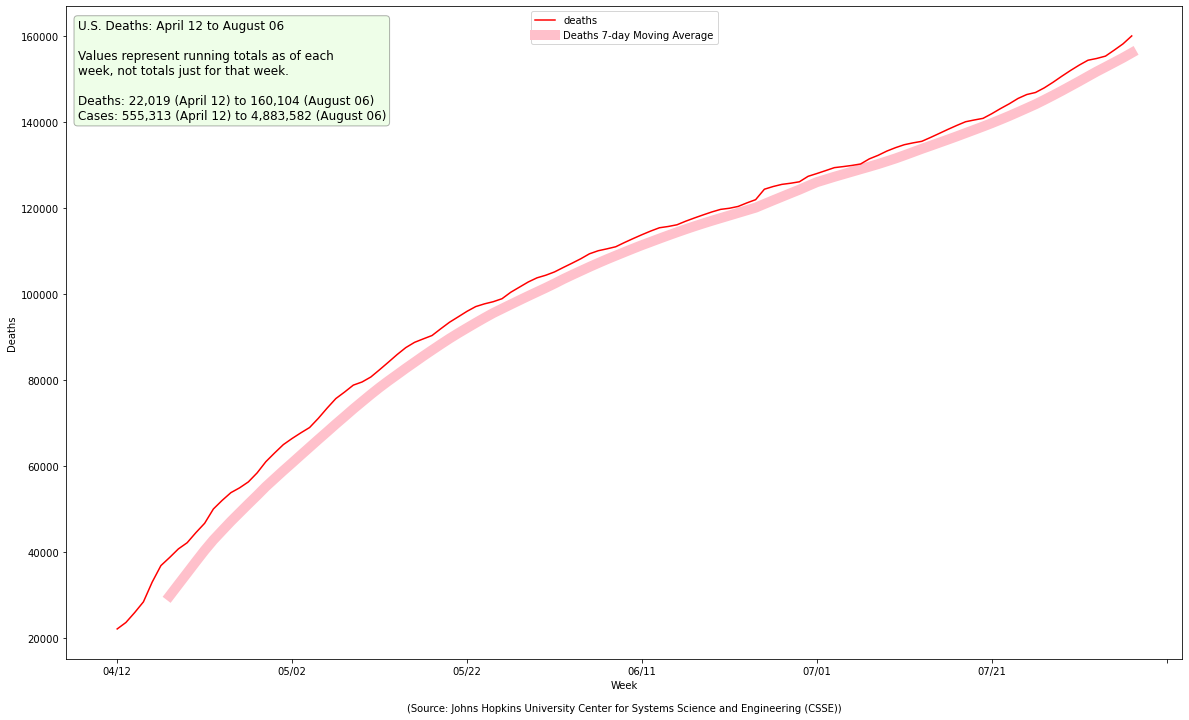

In [9]:
plot_stats_by_date(df, SOURCE, metrics={MetricType.DEATHS}, moving_average=True,
                   image_file='jhu-us-deaths.png', textbox_heading="U.S. Deaths")

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f68e6b89dc0>)

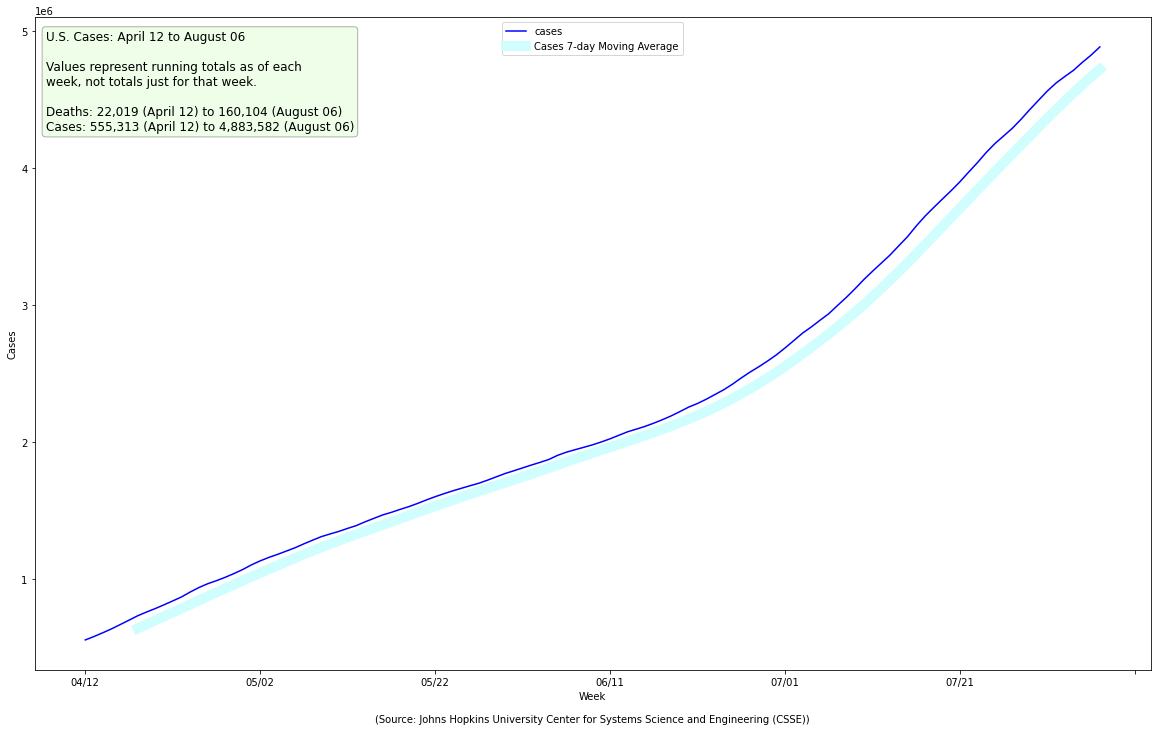

In [10]:
plot_stats_by_date(df, SOURCE, metrics={MetricType.CASES}, moving_average=True,
                   image_file='jhu-us-cases.png', textbox_heading="U.S. Cases")

#### Positivity Rate

The positivity rate is problematic. At the beginning of the pandemic,
we weren't testing much at all, and the tests were reserved largely
for those showing symptoms. So the positivity rate was, not surprisingly,
quite high. It will have declined over time, because we're testing more
of the population, including more people who come up negative.

Rather than plot the positivity rate since April, which is somewhat
misleading, just plot the positivity rate for the last 45 days.

**Note**: A drop-off toward the end isn't necessarily cause for celebration.
Reporting of cases probably lags.

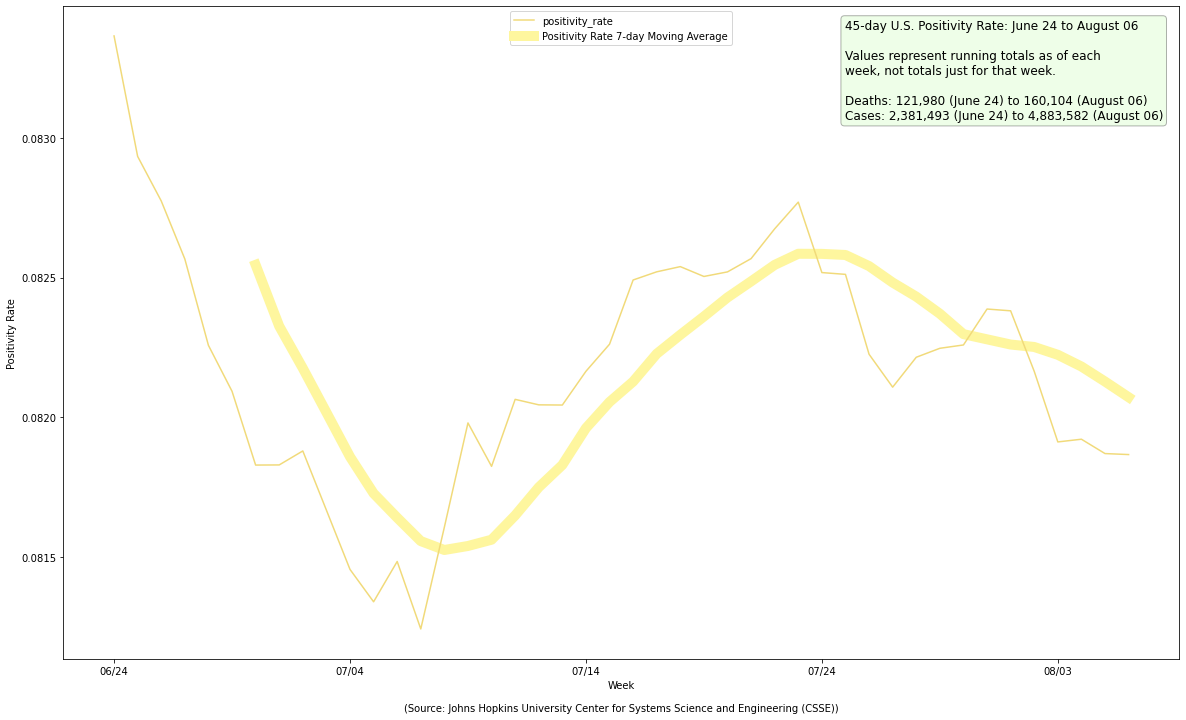

In [11]:
delta = timedelta(days=45)
cutoff = date_to_datetime(today - delta)
df_positivity_dates = df.loc[df.date >= cutoff]
fig, ax = plot_stats_by_date(df_positivity_dates, SOURCE, metrics={MetricType.POSITIVITY},
                             image_file='jhu-us-positivity-rate.png', 
                             textbox_heading="45-day U.S. Positivity Rate",
                             textbox_loc=(0.7, 0.98),
                             moving_average=True)

#### Daily values, instead of cumulative values

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f68e6637c40>)

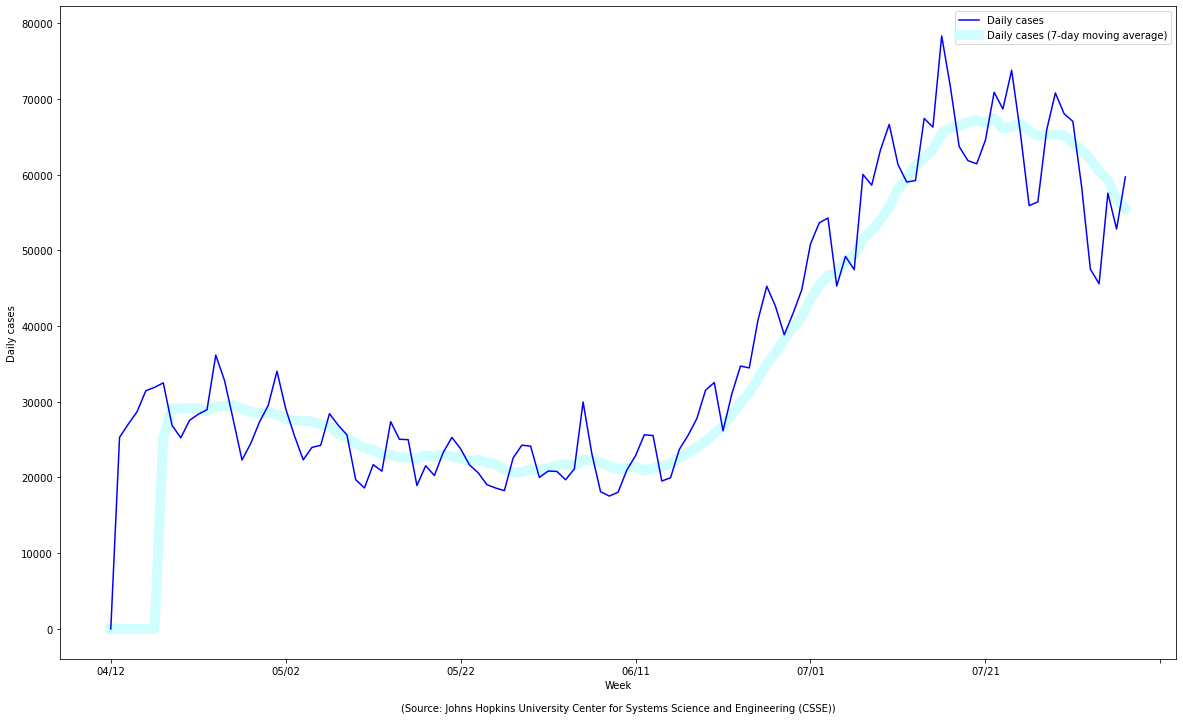

In [12]:
plot_daily_stats(df, 
                 source=SOURCE,
                 metric=MetricType.CASES,
                 region='United States',
                 moving_average=True,
                 image_file="jhu-us-cases-daily.png")

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f68e69c59a0>)

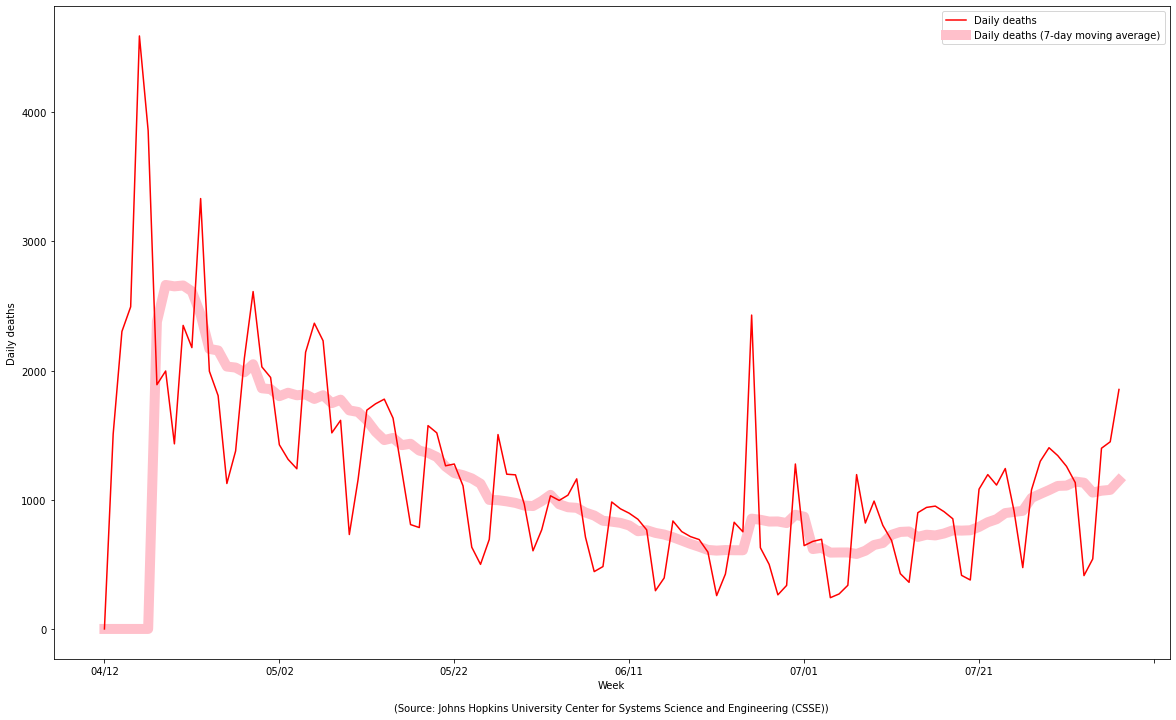

In [13]:
plot_daily_stats(df, 
                 source=SOURCE,
                 metric=MetricType.DEATHS,
                 region='United States',
                 moving_average=True,
                 image_file="jhu-us-deaths-daily.png")

#### Just the past week

In [14]:
week_delta = timedelta(days=6)
six_days_prior = jhu_ending_date - week_delta
last_week_start = date_to_datetime(six_days_prior)
last_week_end = date_to_datetime(jhu_ending_date, hour=23, minute=59, second=59)

df_past_week = df.loc[(df[COL_DATE] >= last_week_start) & (df[COL_DATE] <= last_week_end)]

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f68e693d700>)

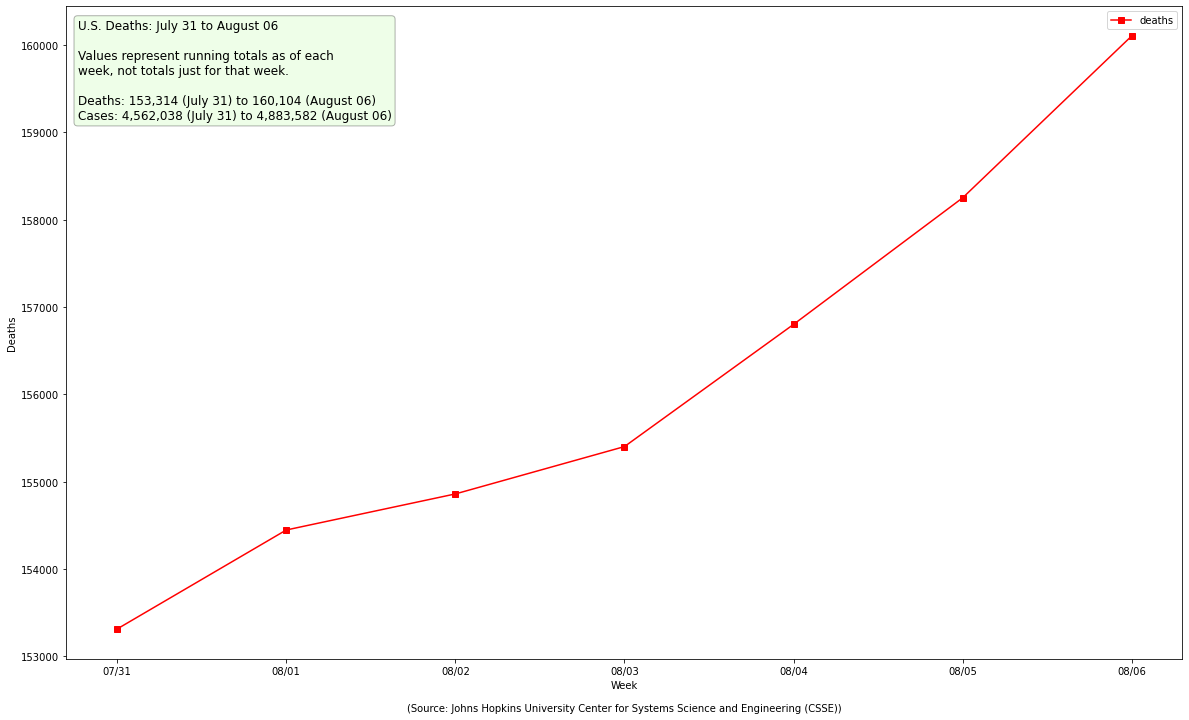

In [15]:
plot_stats_by_date(df_past_week, SOURCE, metrics={MetricType.DEATHS}, marker='s', 
                   textbox_heading="U.S. Deaths", image_file='jhu-us-deaths-past-week.png')

#### Deaths vs. Cases

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f68e6908490>)

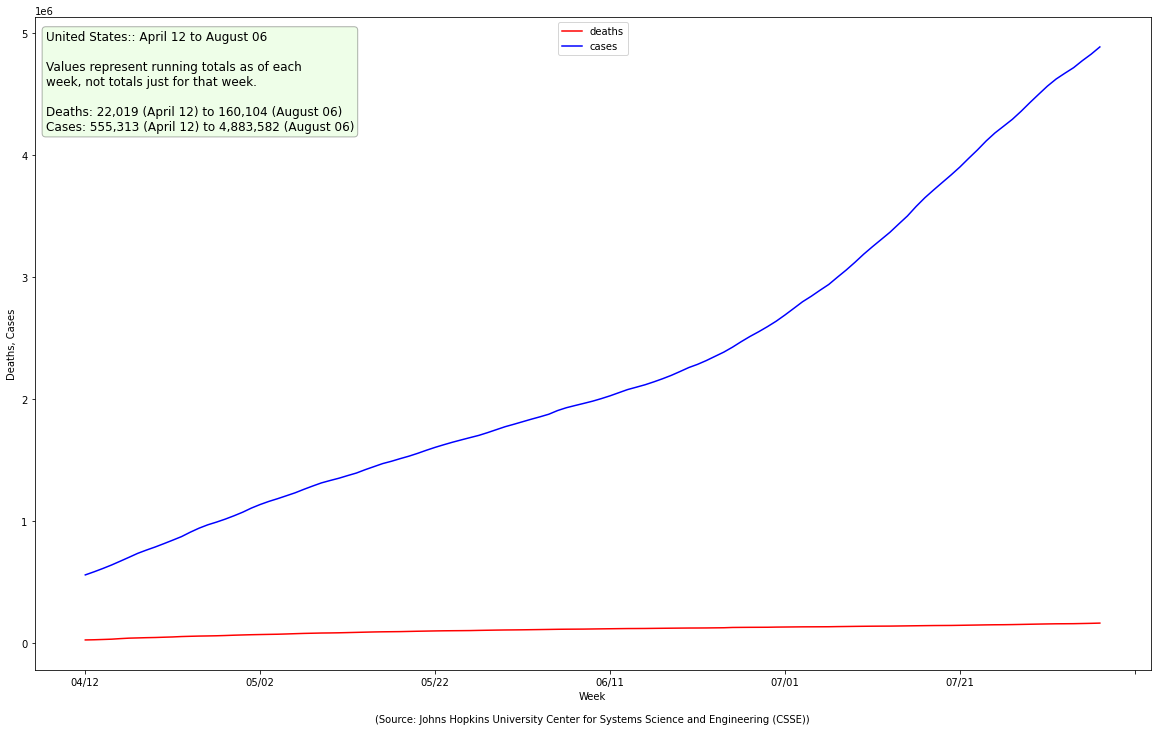

In [16]:
plot_stats_by_date(df, SOURCE, metrics={MetricType.DEATHS, MetricType.CASES}, 
                   textbox_heading="United States:", image_file="jhu-us-deaths-and-cases.png")

### Individual States

#### Pennsylvania

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f68e6871ac0>)

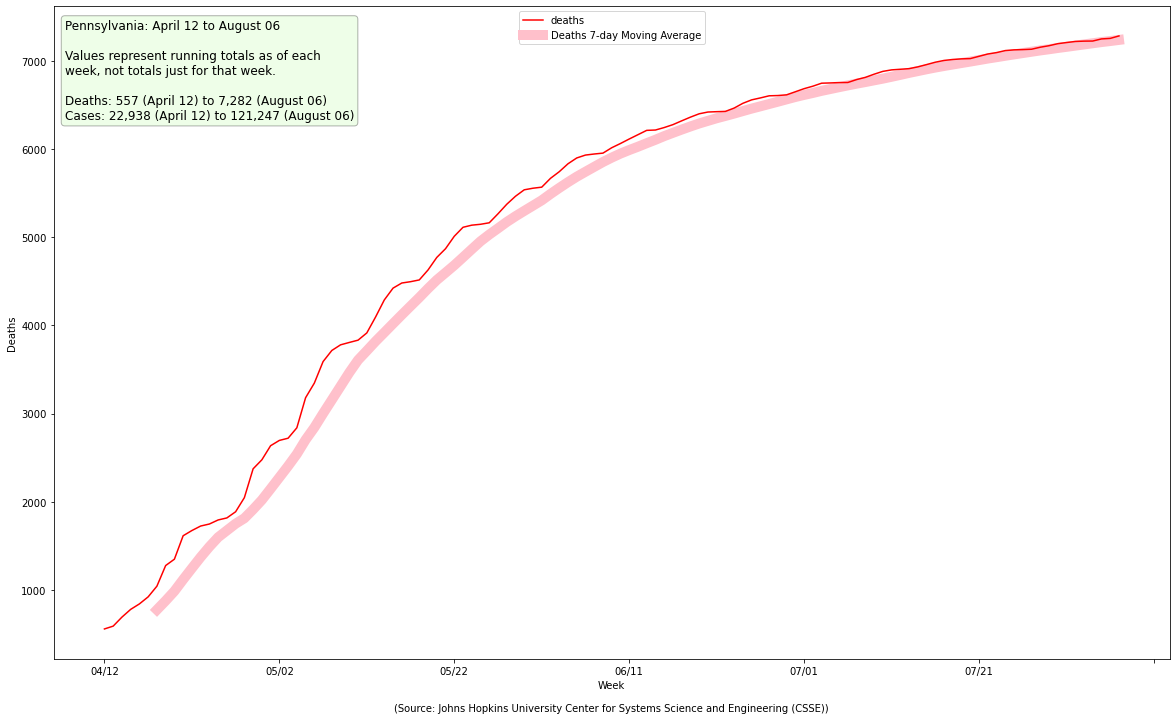

In [17]:
plot_state(df, SOURCE, 'Pennsylvania', image_file='jhu-pa-deaths.png', metrics={MetricType.DEATHS}, moving_average=True)

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f68e6815fd0>)

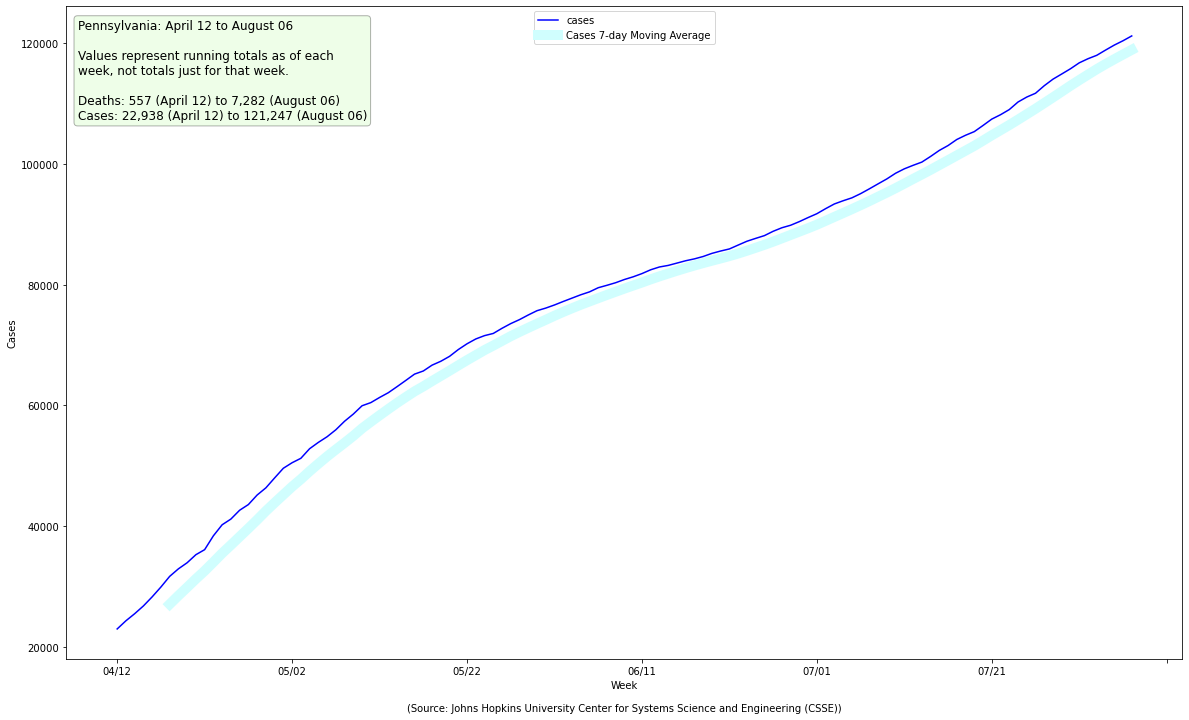

In [18]:
plot_state(df, SOURCE, 'Pennsylvania', image_file='jhu-pa-cases.png', metrics={MetricType.CASES}, moving_average=True)

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f68e67c8190>)

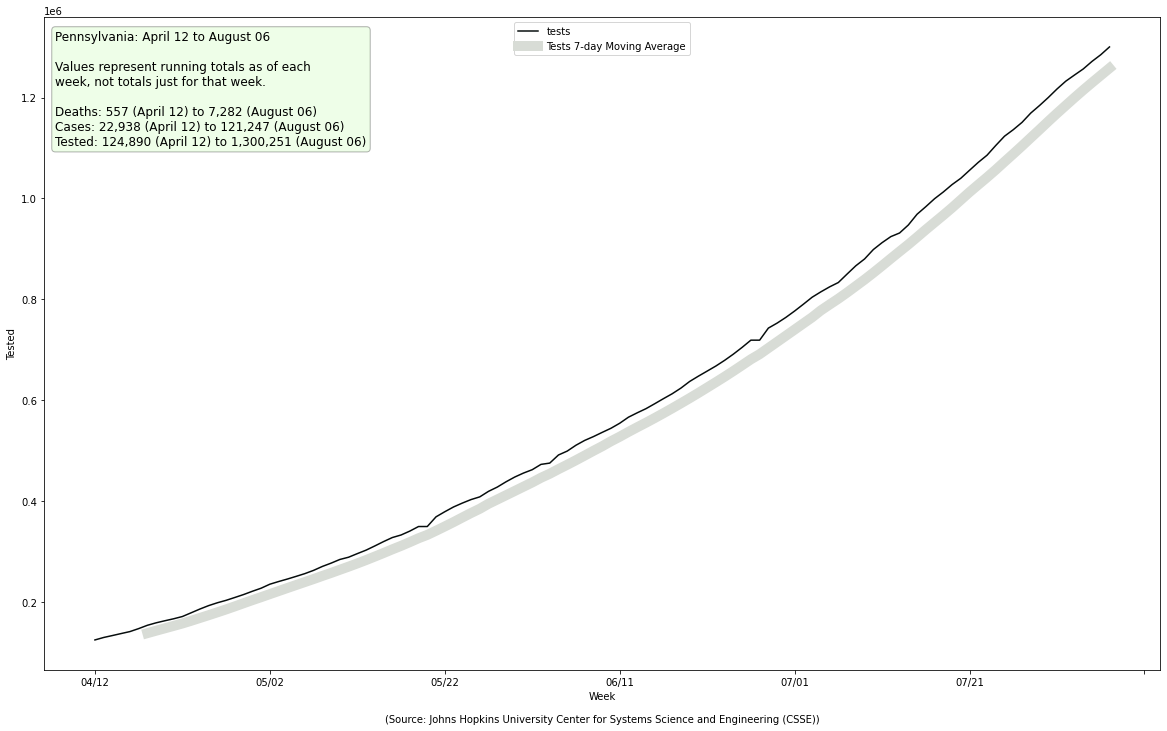

In [19]:
plot_state(df, SOURCE, 'Pennsylvania', image_file='jhu-pa-tests.png', metrics={MetricType.TESTED}, moving_average=True)

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f68e672ed30>)

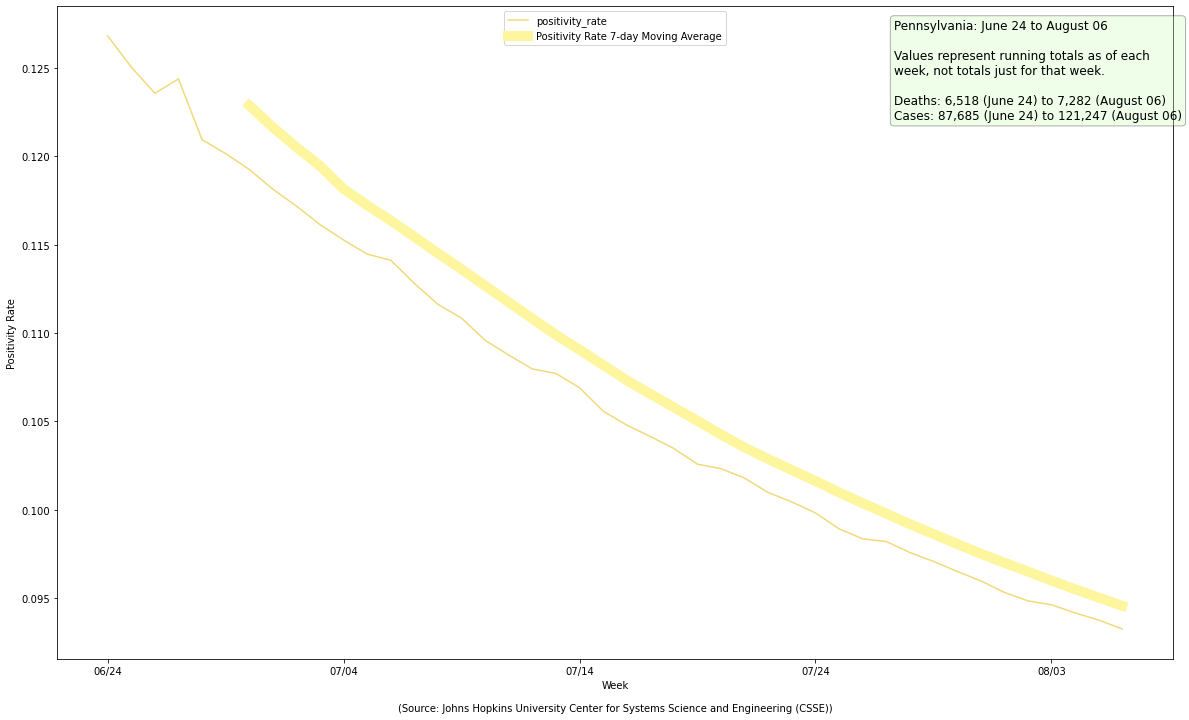

In [20]:
# Note caveats on positivity rate in the U.S. section, above.
plot_state(df_positivity_dates, SOURCE, 'Pennsylvania', metrics={MetricType.POSITIVITY},
           image_file='jhu-pa-positivity.png', moving_average=True, textbox_loc=(0.75, 0.98))

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f68e66ebd30>)

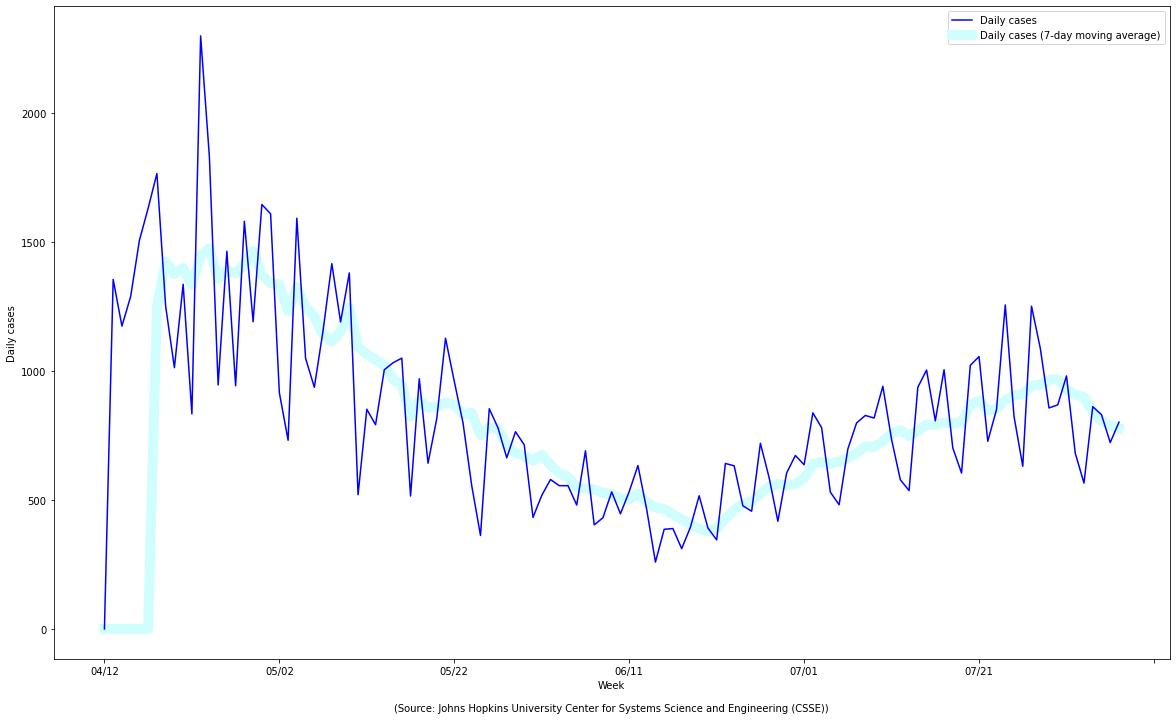

In [21]:
plot_daily_stats(df, 
                 source=SOURCE,
                 metric=MetricType.CASES,
                 region='Pennsylvania',
                 moving_average=True,
                 image_file="jhu-pa-cases-daily.png")

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f68e42afd90>)

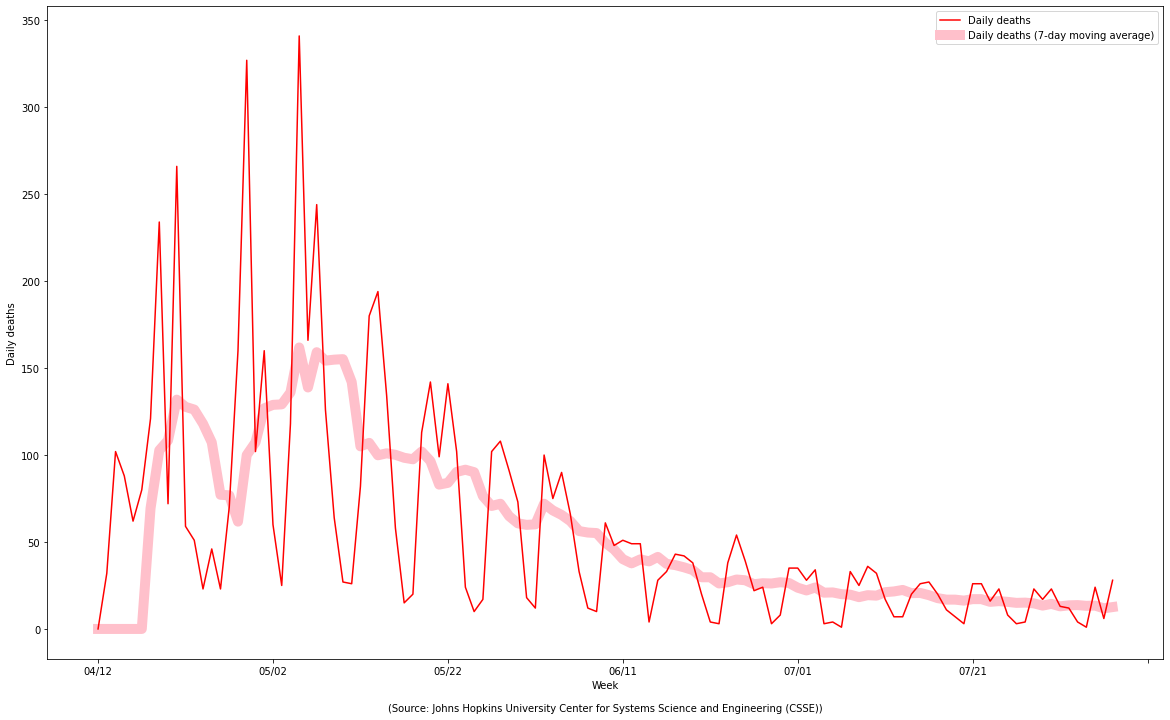

In [22]:
plot_daily_stats(df, 
                 source=SOURCE,
                 metric=MetricType.DEATHS,
                 region='Pennsylvania',
                 moving_average=True,
                 image_file="jhu-pa-deaths-daily.png")

#### New York

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f68e4219220>)

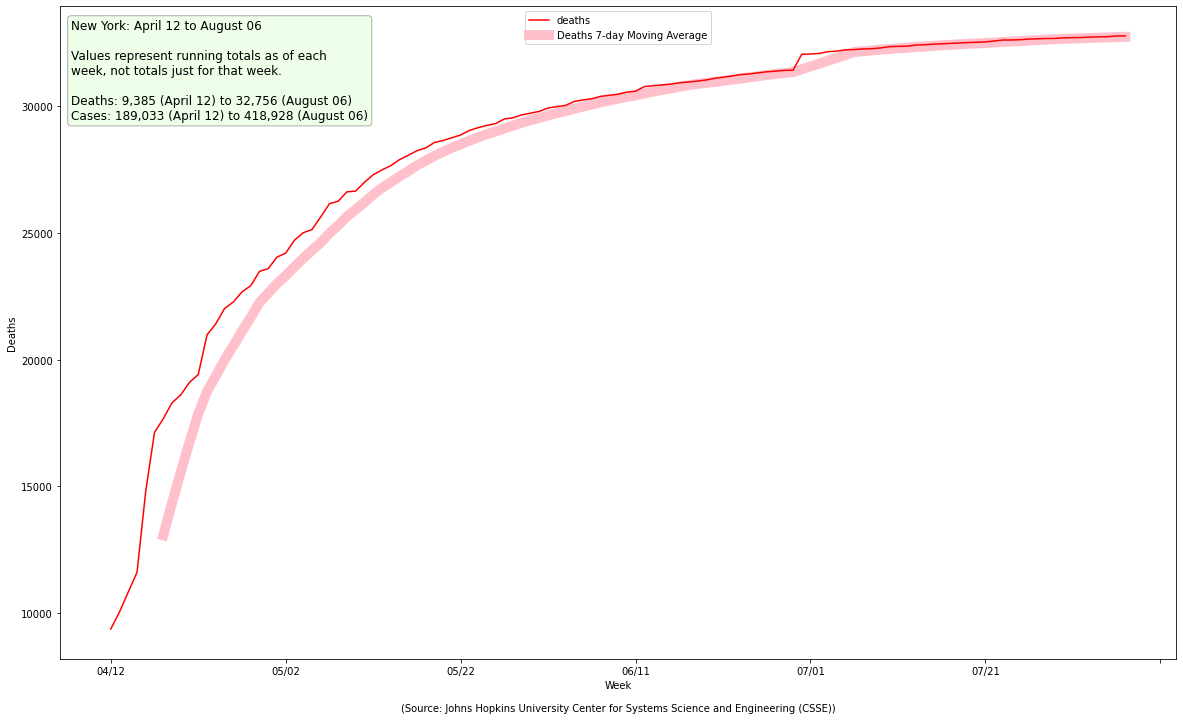

In [23]:
plot_state(df, SOURCE, 'New York', image_file='jhu-ny-deaths.png', metrics={MetricType.DEATHS}, moving_average=True)

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f68e41fd940>)

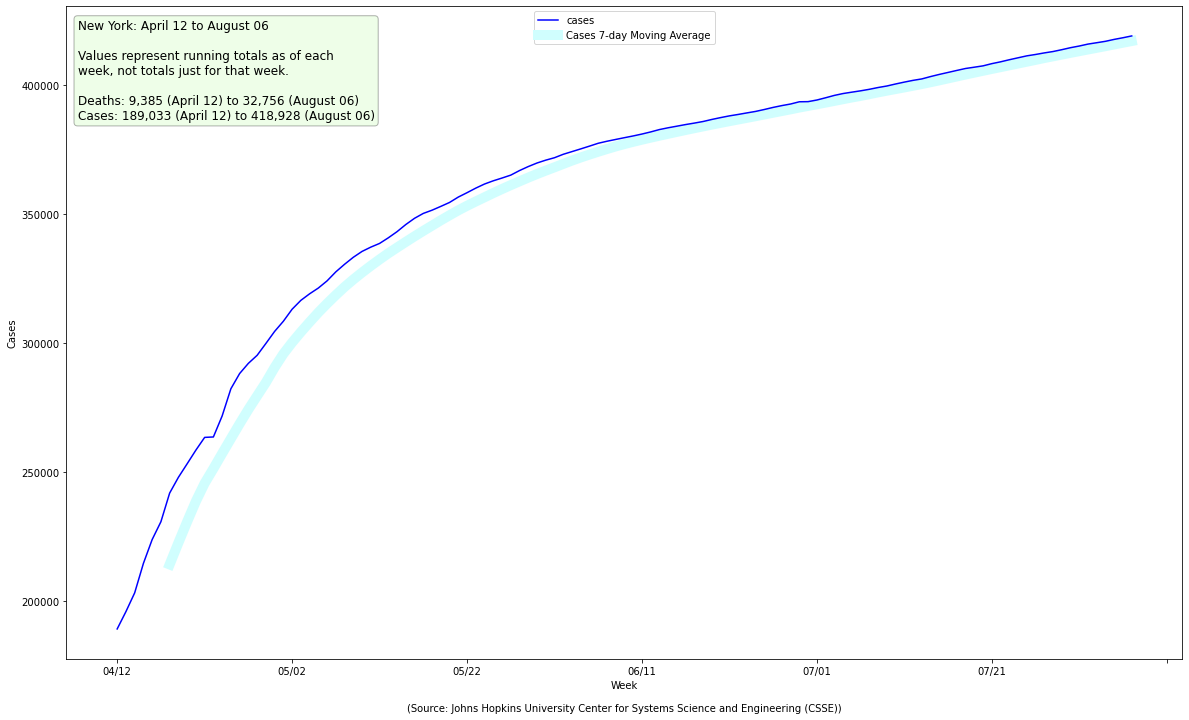

In [24]:
plot_state(df, SOURCE, 'New York', image_file='jhu-ny-cases.png', metrics={MetricType.CASES}, moving_average=True)

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f68e4163700>)

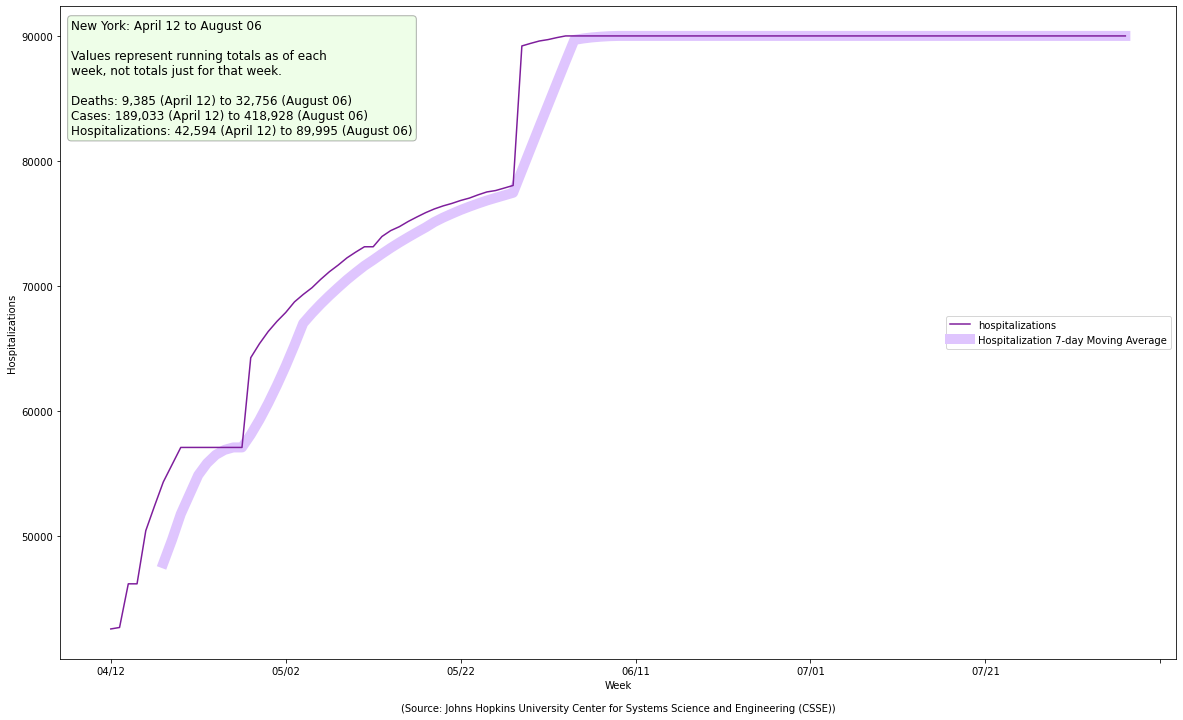

In [25]:
plot_state(df, SOURCE, 'New York', image_file='jhu-ny-hosp.png', metrics={MetricType.HOSPITALIZATIONS}, 
           moving_average=True, legend_loc='center right')

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f68e4137e50>)

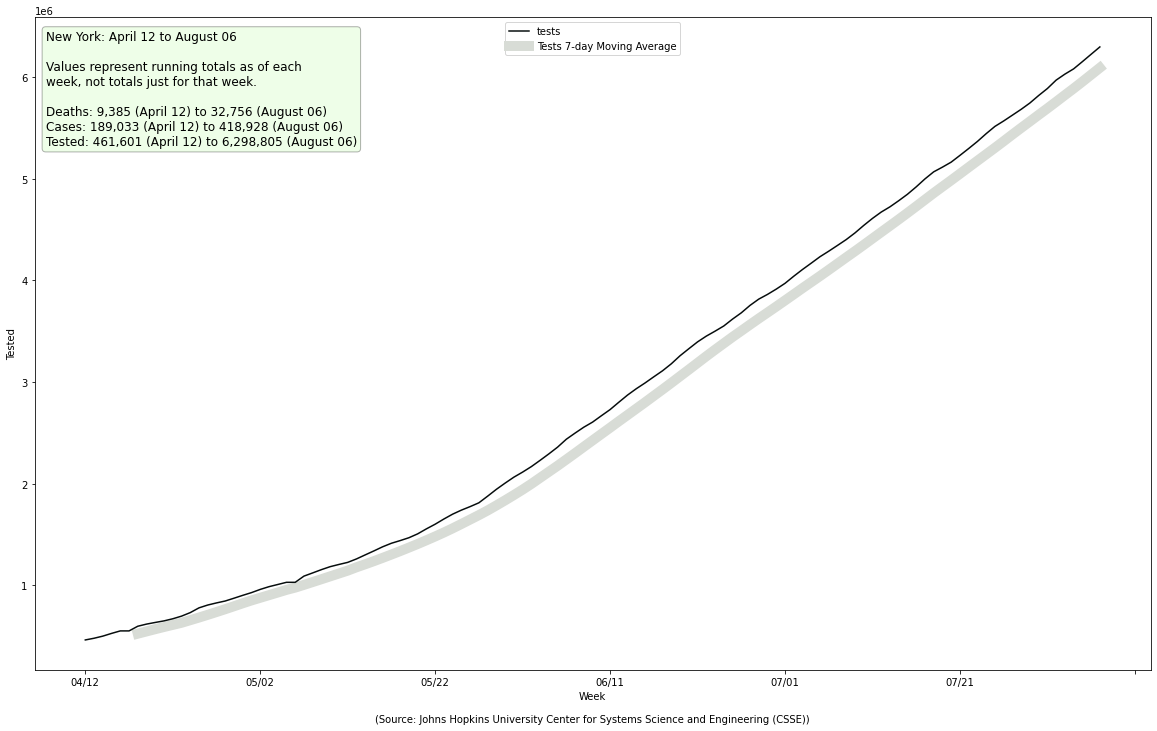

In [26]:
plot_state(df, SOURCE, 'New York', image_file='jhu-ny-tests.png', metrics={MetricType.TESTED}, moving_average=True)

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f68e6725f10>)

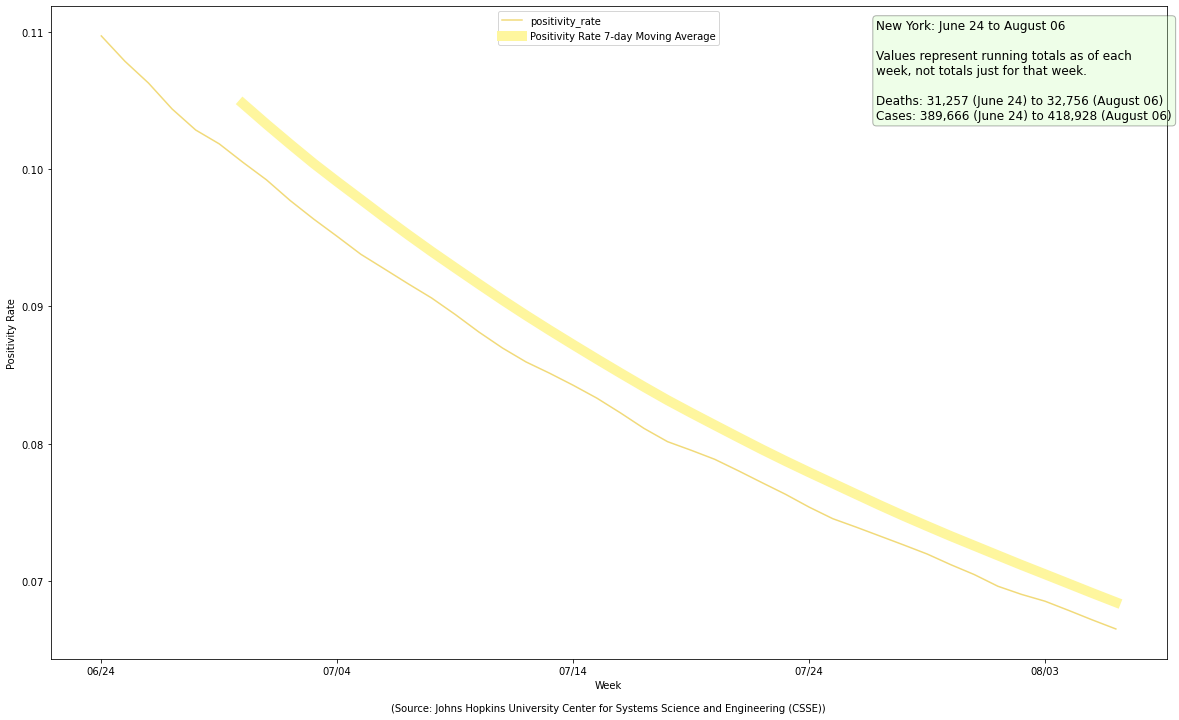

In [27]:
plot_state(df_positivity_dates, SOURCE, 'New York', image_file='jhu-ny-pos.png', 
           metrics={MetricType.POSITIVITY}, textbox_loc=(0.74, 0.98), moving_average=True)

#### California

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f68e41f65e0>)

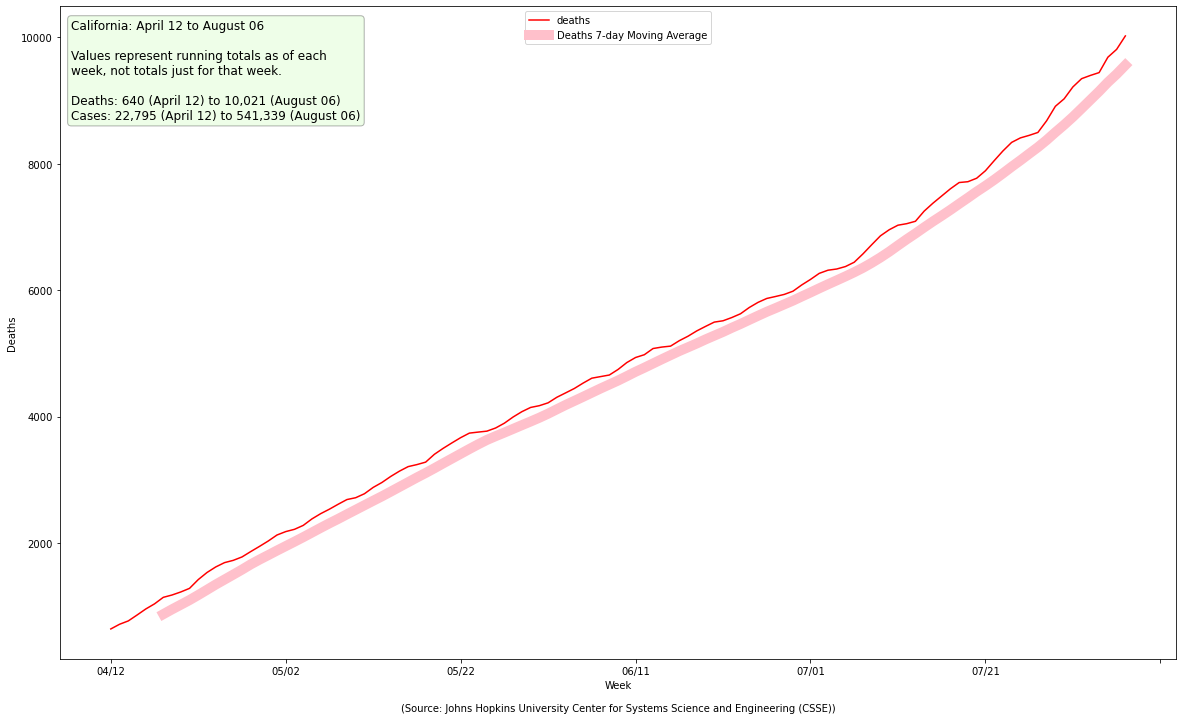

In [28]:
plot_state(df, SOURCE, 'California', image_file='jhu-ca-deaths.png', metrics={MetricType.DEATHS}, moving_average=True)

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f68e404a7f0>)

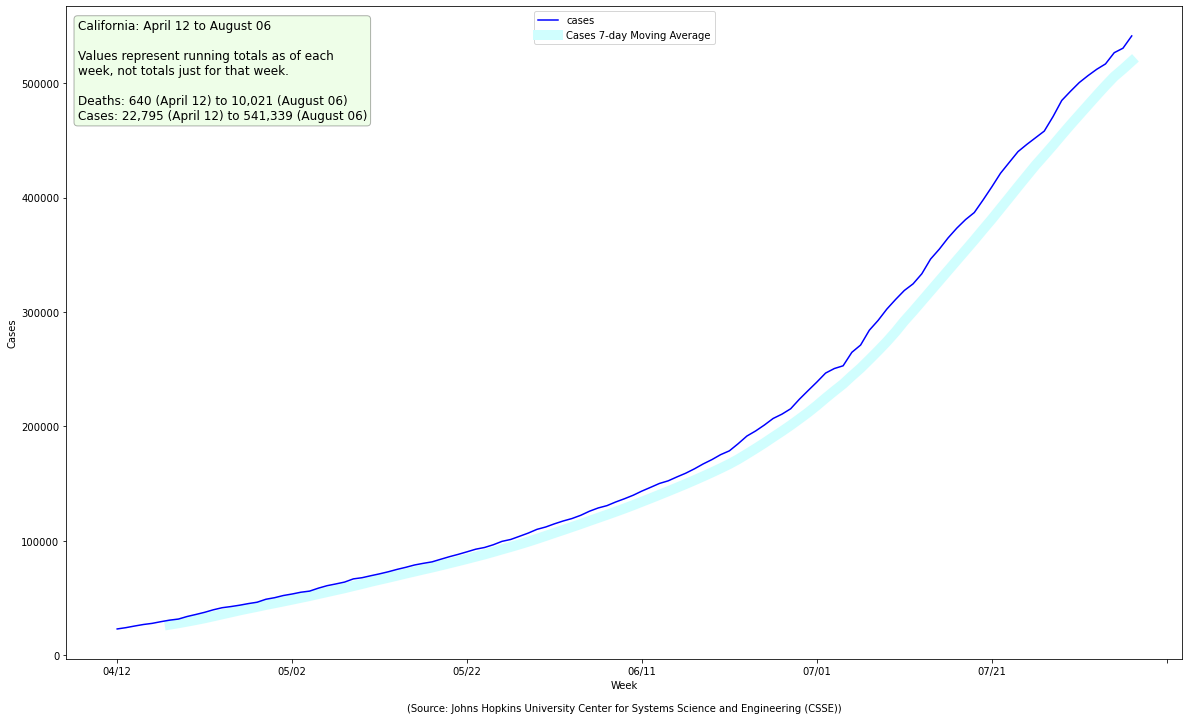

In [29]:
plot_state(df, SOURCE, 'California', image_file='jhu-ca-cases.png', metrics={MetricType.CASES}, moving_average=True)

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f68dd7a5b50>)

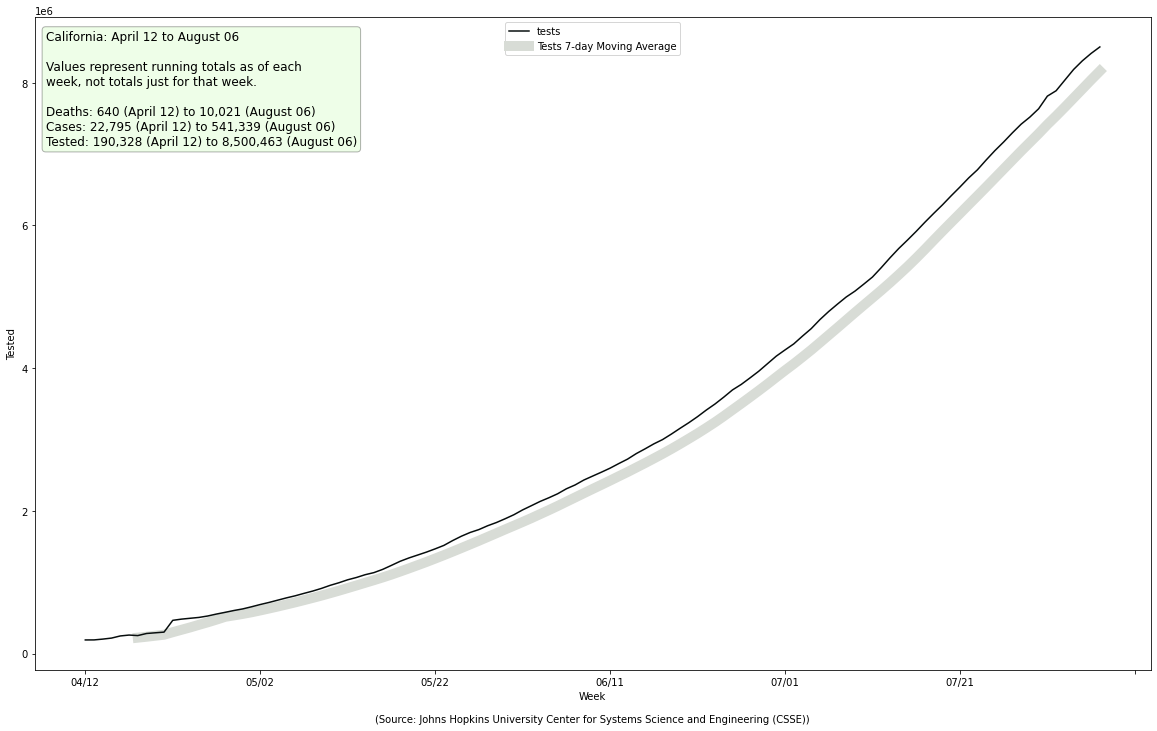

In [30]:
plot_state(df, SOURCE, 'California', image_file='jhu-ca-tests.png', 
           metrics={MetricType.TESTED}, moving_average=True)

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f68dd75b070>)

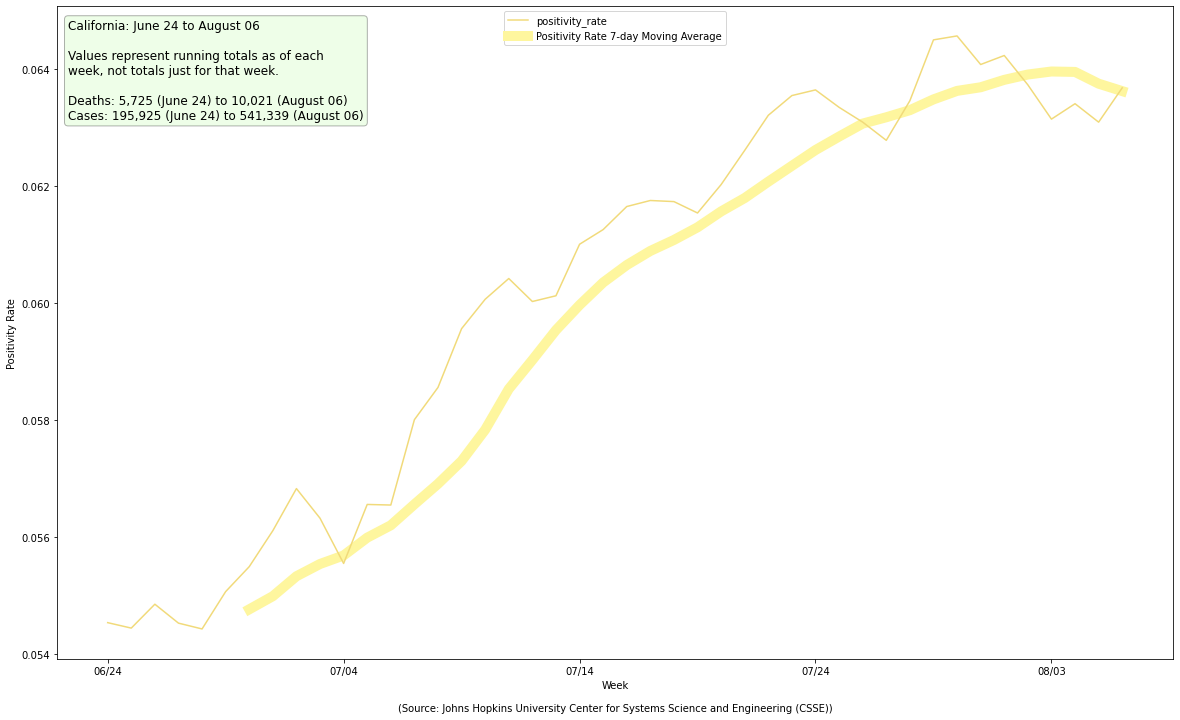

In [31]:
plot_state(df_positivity_dates, SOURCE, 'California', image_file='jhu-ca-pos.png', 
           metrics={MetricType.POSITIVITY}, moving_average=True)

#### Washington

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f68dd6d21f0>)

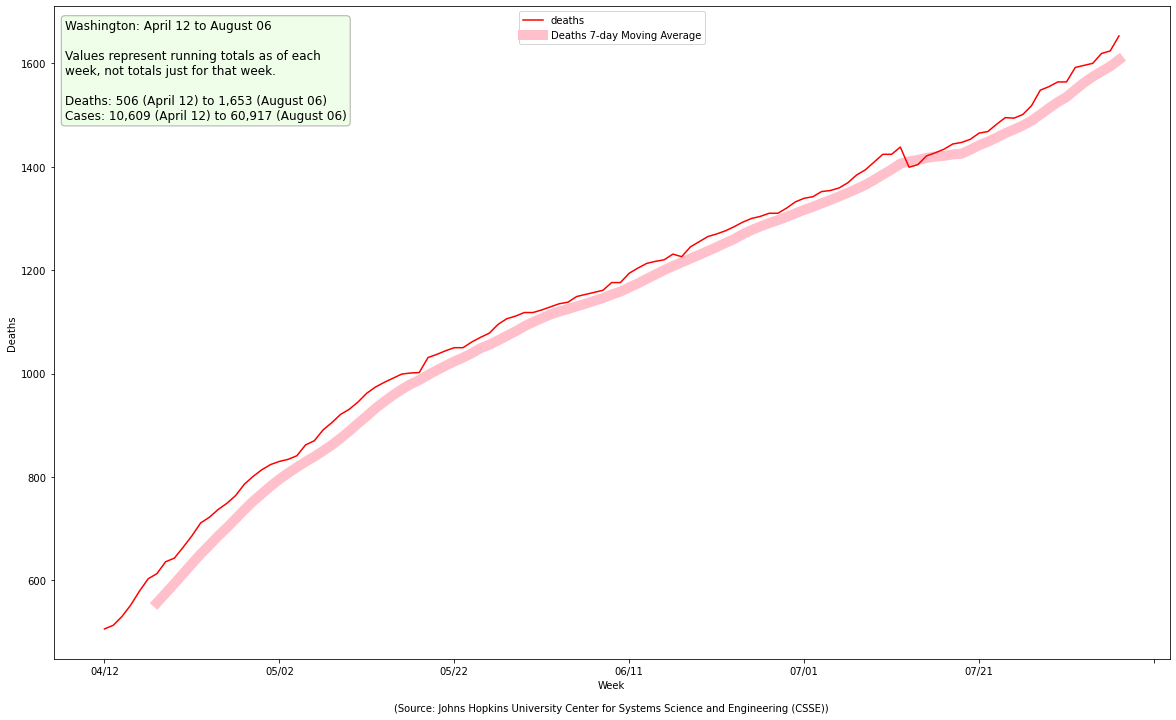

In [32]:
plot_state(df, SOURCE, 'Washington', image_file='jhu-wa-deaths.png', metrics={MetricType.DEATHS}, moving_average=True)

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f68dd65b370>)

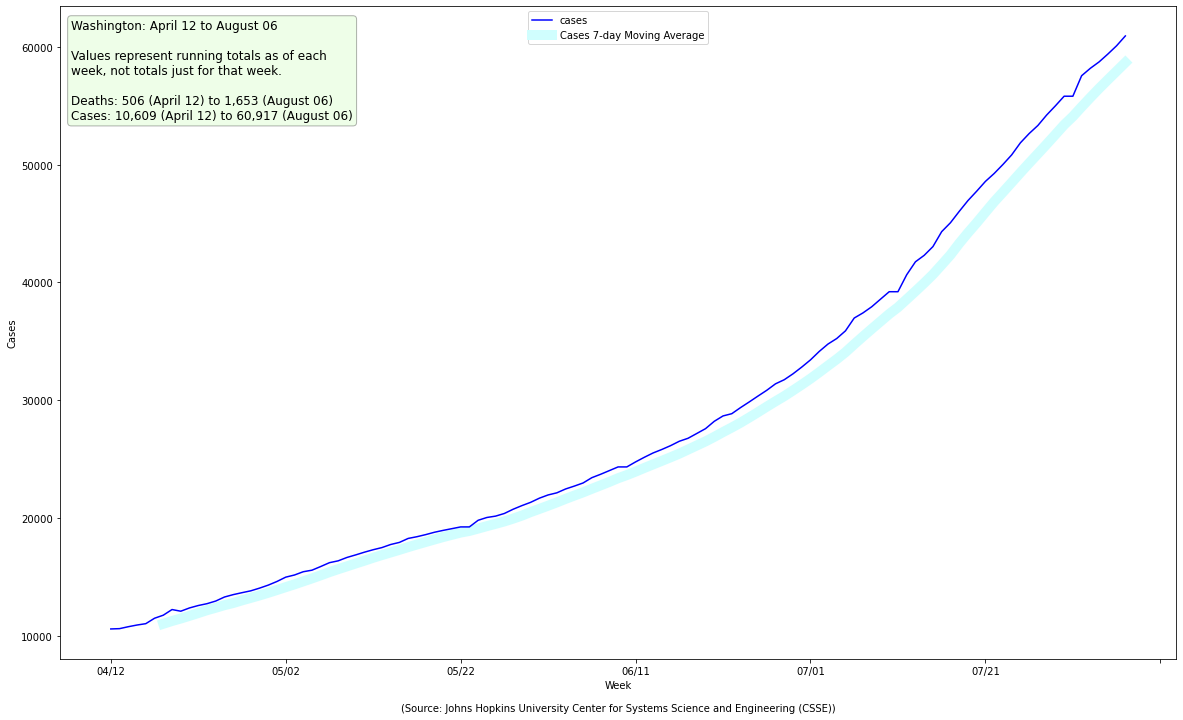

In [33]:
plot_state(df, SOURCE, 'Washington', image_file='jhu-wa-cases.png', metrics={MetricType.CASES}, moving_average=True)

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f68dd5bed00>)

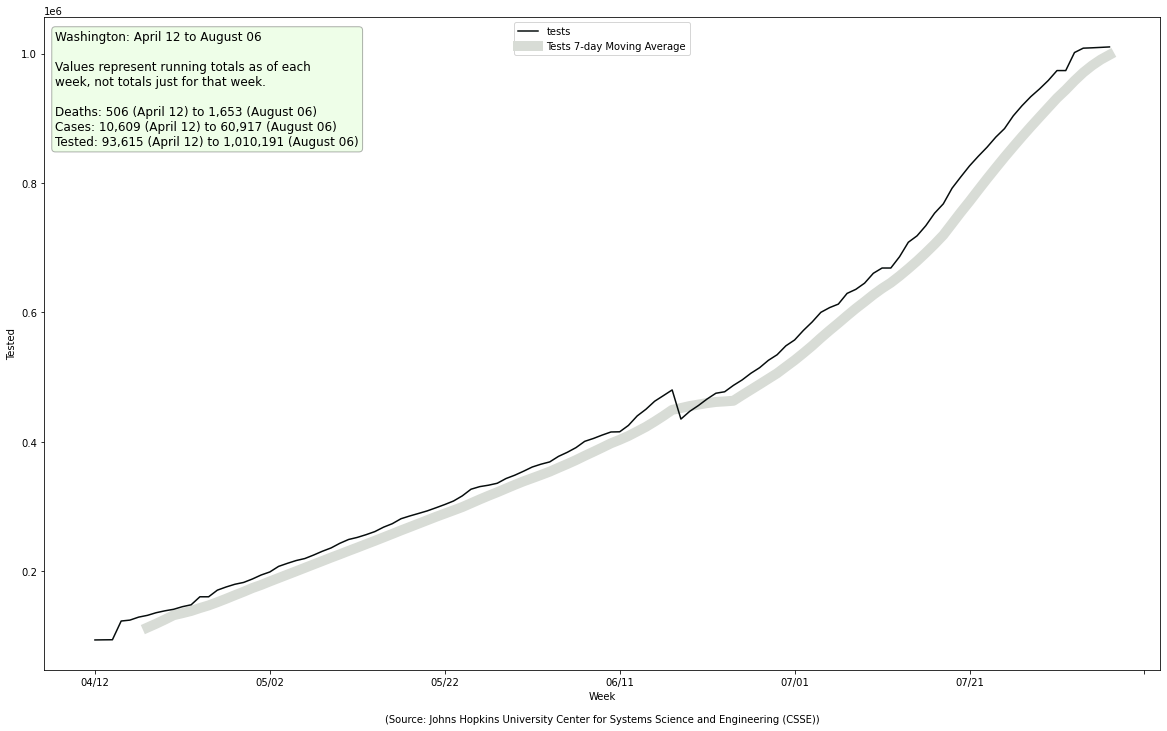

In [34]:
plot_state(df, SOURCE, 'Washington', image_file='jhu-wa-tests.png', metrics={MetricType.TESTED}, moving_average=True)

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f68dd5a25e0>)

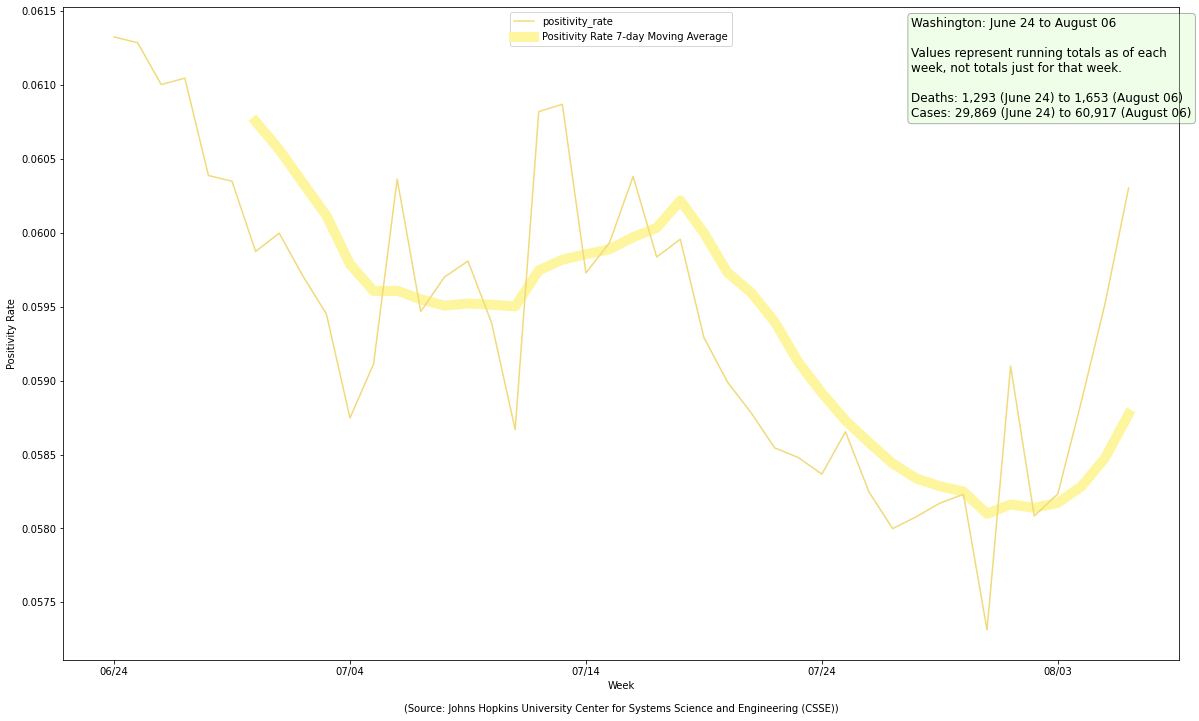

In [35]:
plot_state(df_positivity_dates, SOURCE, 'Washington', image_file='jhu-wa-pos.png', 
           metrics={MetricType.POSITIVITY}, moving_average=True, textbox_loc=(0.76, 0.985))

#### Delaware

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f68dd567fd0>)

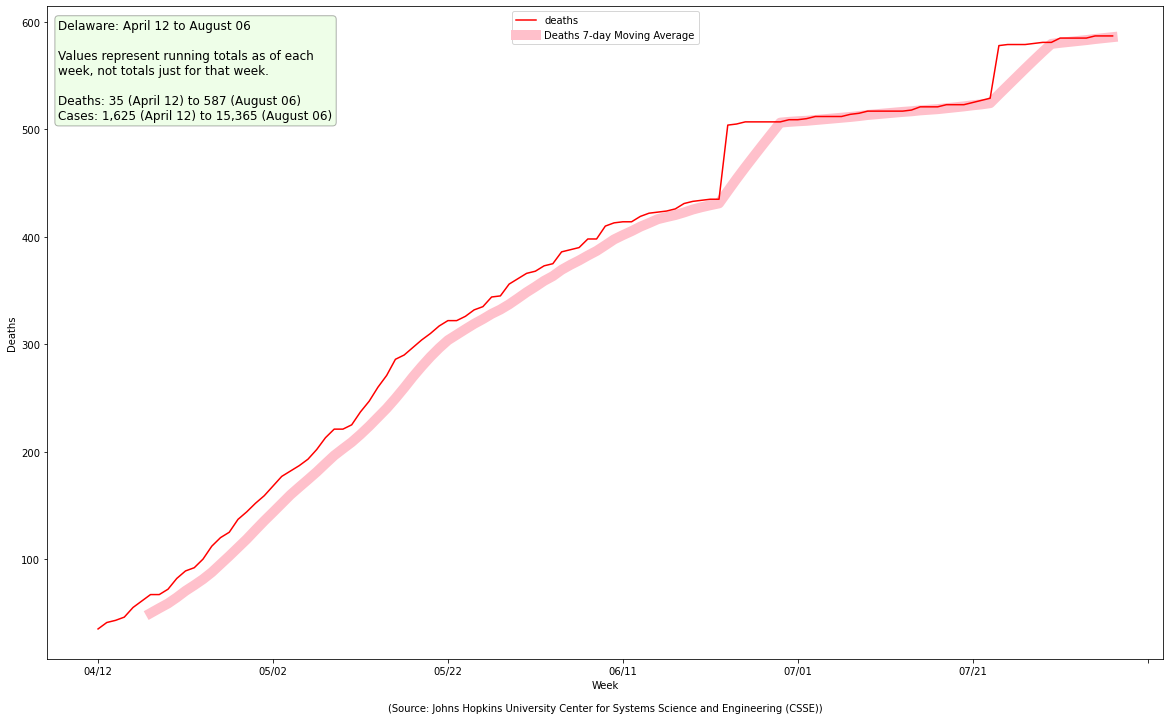

In [36]:
plot_state(df, SOURCE, 'Delaware', image_file='jhu-de-deaths.png', metrics={MetricType.DEATHS}, moving_average=True)

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f68dd4d1940>)

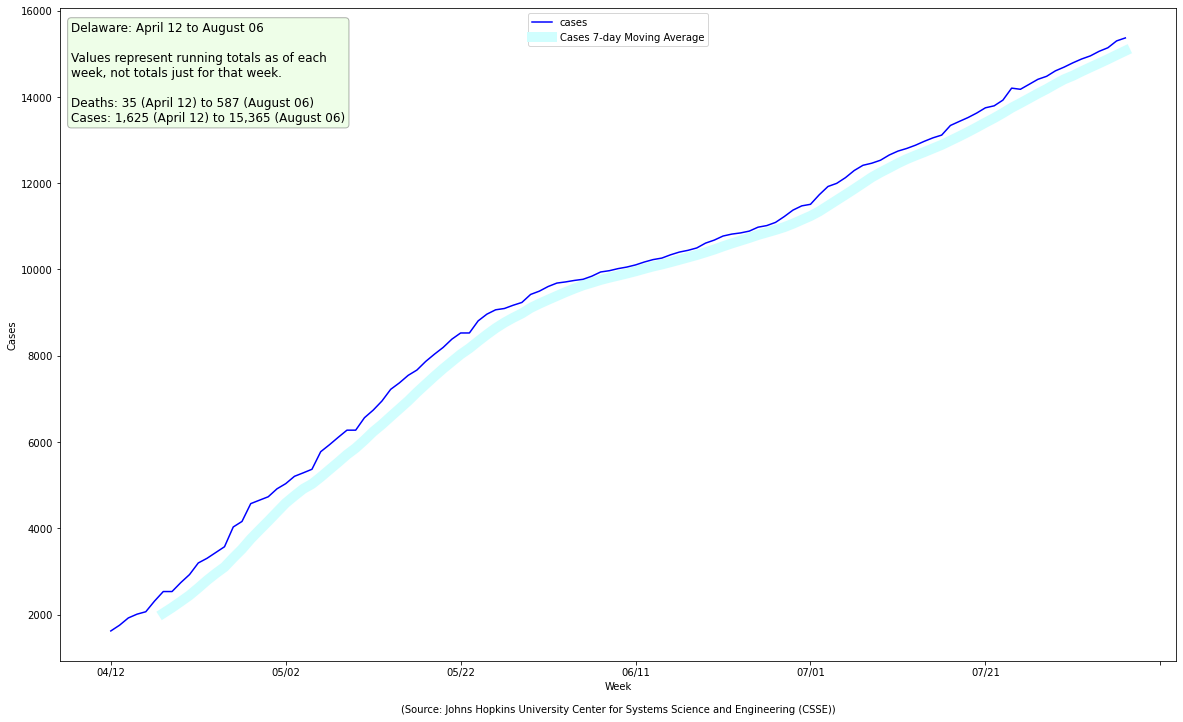

In [37]:
plot_state(df, SOURCE, 'Delaware', image_file='jhu-de-cases.png', metrics={MetricType.CASES}, moving_average=True)

#### Texas

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f68dd462f40>)

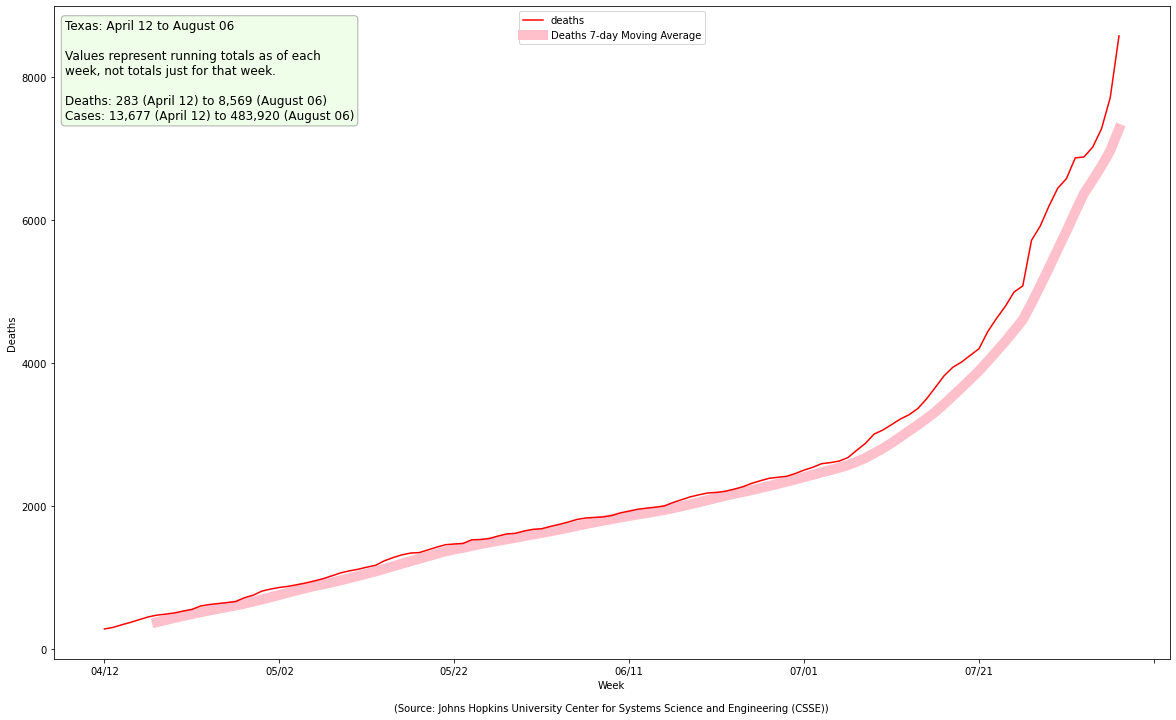

In [38]:
plot_state(df, SOURCE, 'Texas', image_file='jhu-tx-deaths.png', metrics={MetricType.DEATHS}, moving_average=True)

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f68e4022730>)

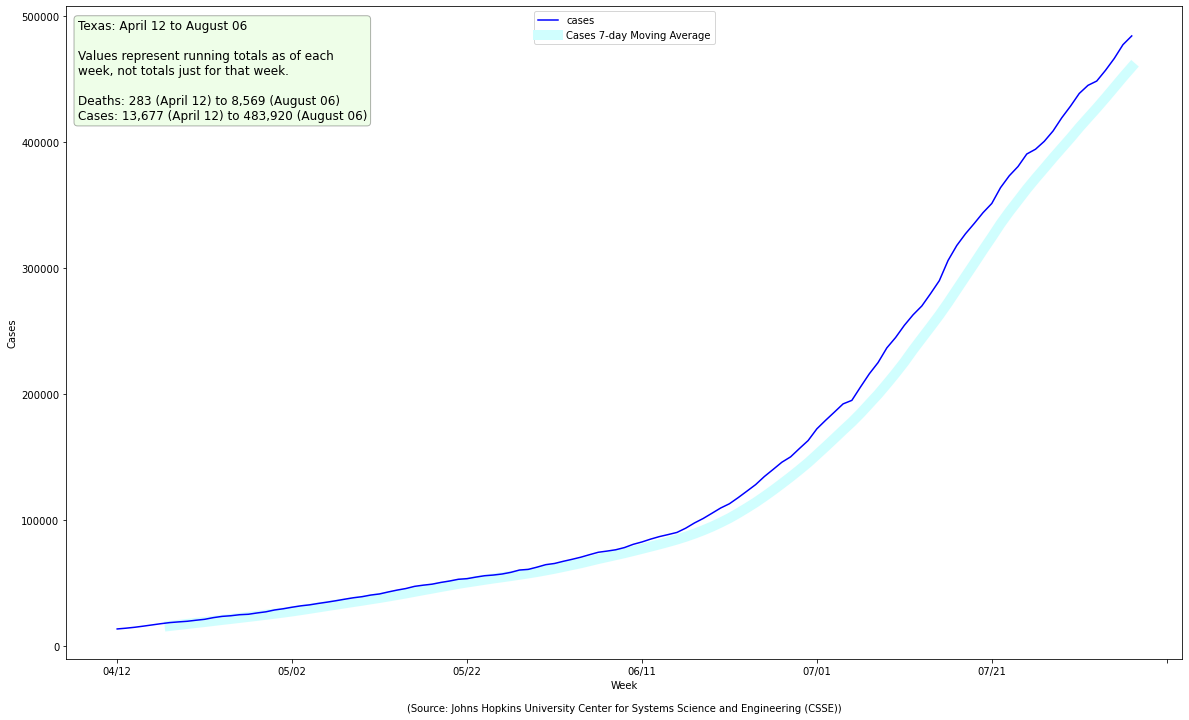

In [39]:
plot_state(df, SOURCE, 'Texas', image_file='jhu-tx-cases.png', metrics={MetricType.CASES}, moving_average=True)

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f68dd3ee730>)

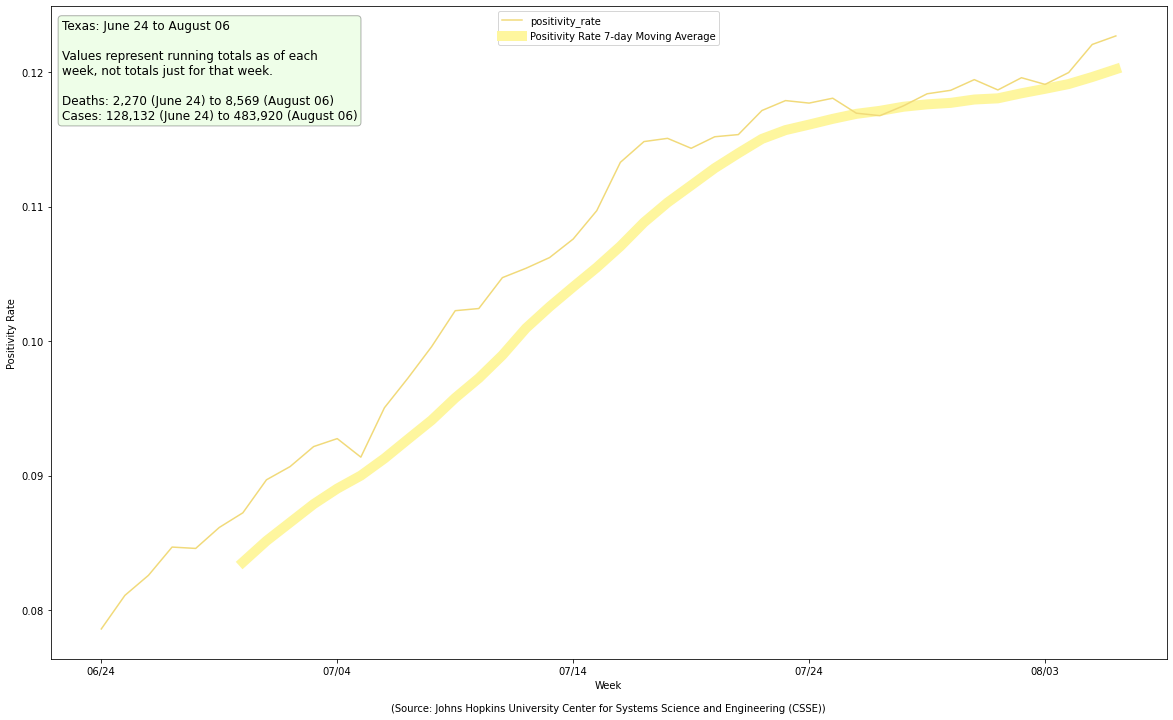

In [40]:
plot_state(df_positivity_dates, SOURCE, 'Texas', image_file='jhu-tx-pos.png', metrics={MetricType.POSITIVITY}, moving_average=True)

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f68dd3aea90>)

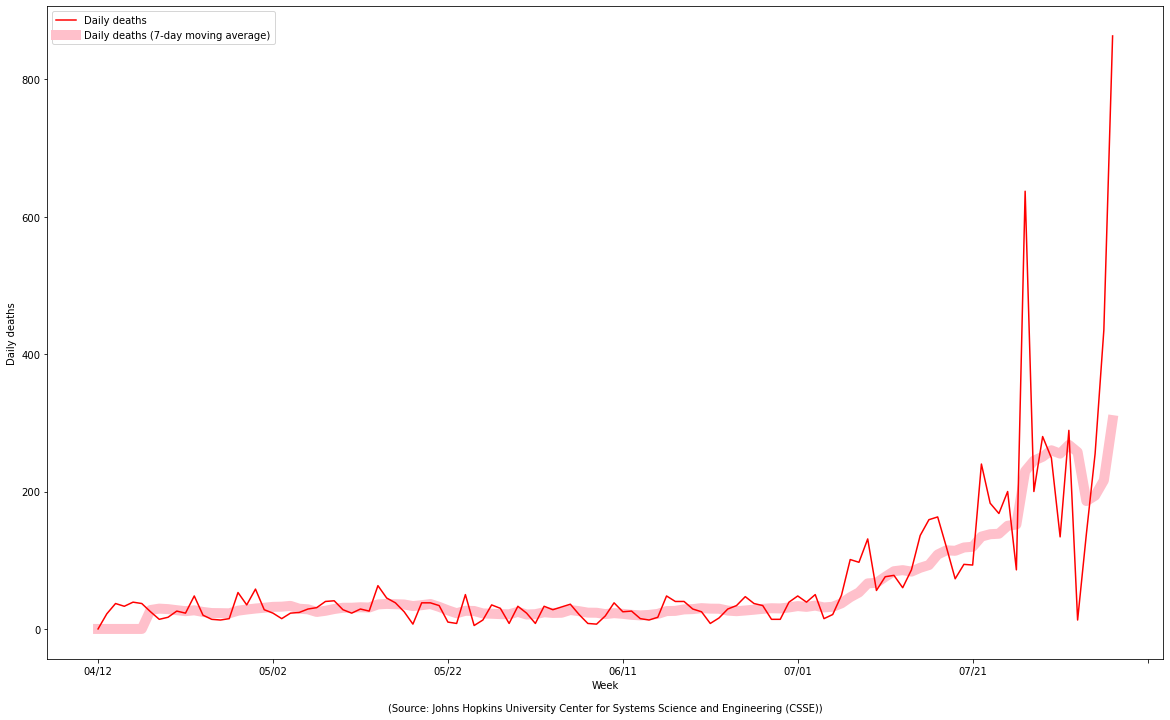

In [41]:
plot_daily_stats(df, SOURCE, region='Texas', metric=MetricType.DEATHS, moving_average=True, image_file="jhu-tx-daily-deaths.png")

#### Georgia

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f68dd32f700>)

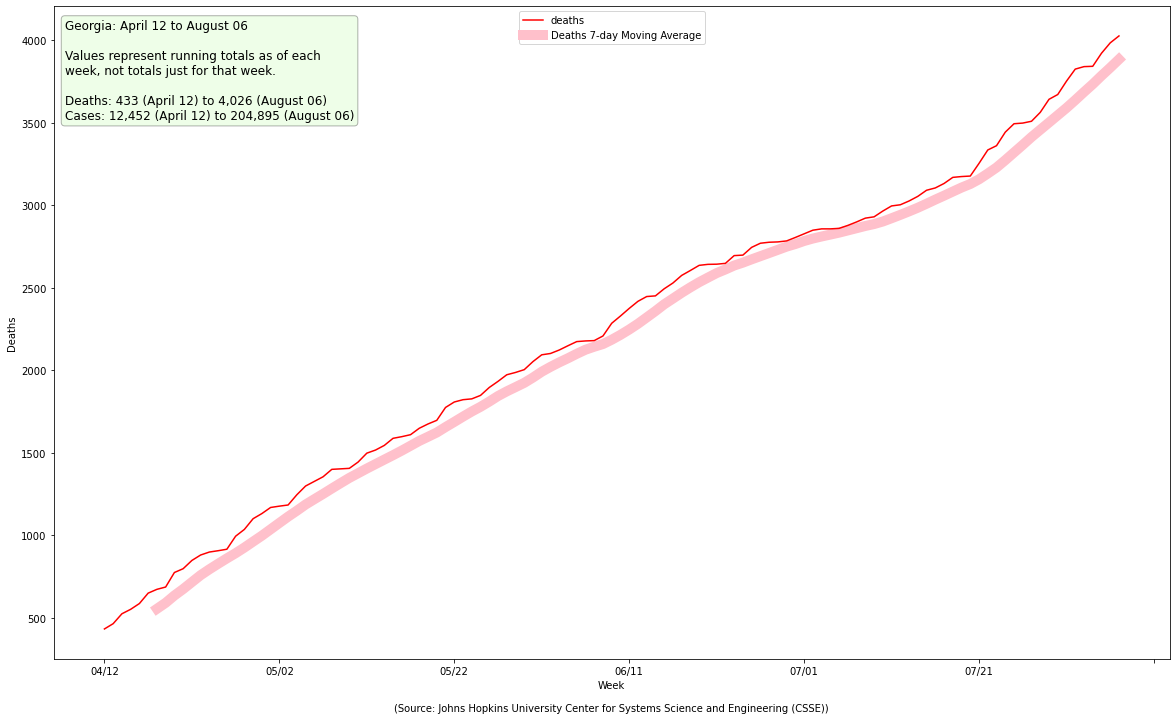

In [42]:
plot_state(df, SOURCE, 'Georgia', image_file='jhu-ga-deaths.png', metrics={MetricType.DEATHS}, moving_average=True)

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f68dd299100>)

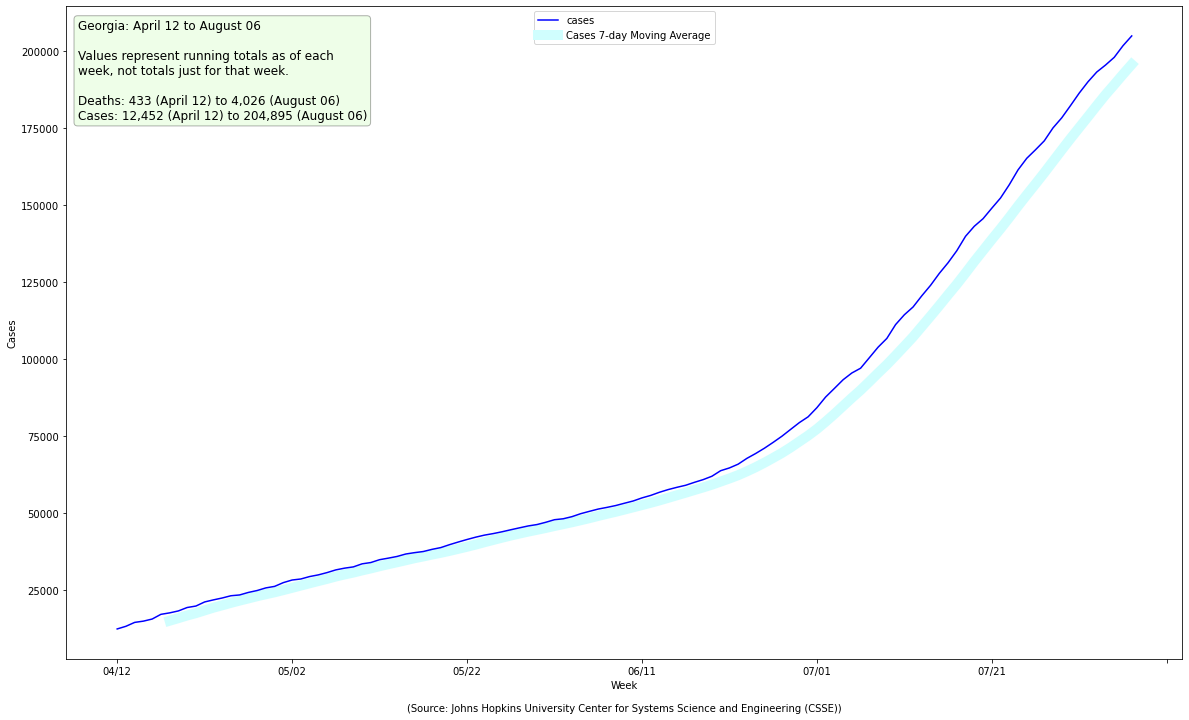

In [43]:
plot_state(df, SOURCE, 'Georgia', image_file='jhu-ga-cases.png', metrics={MetricType.CASES}, moving_average=True)

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f68dd252730>)

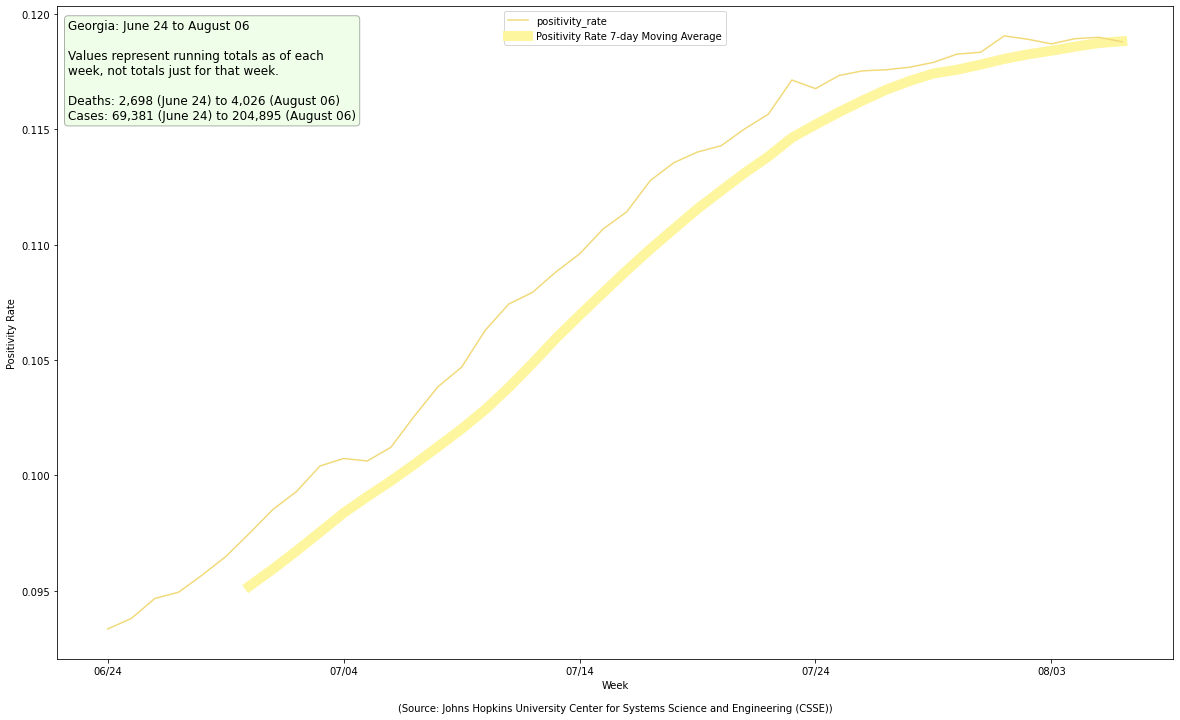

In [44]:
plot_state(df_positivity_dates, SOURCE, 'Georgia', image_file='jhu-ga-pos.png', metrics={MetricType.POSITIVITY}, moving_average=True)

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f68dd278e50>)

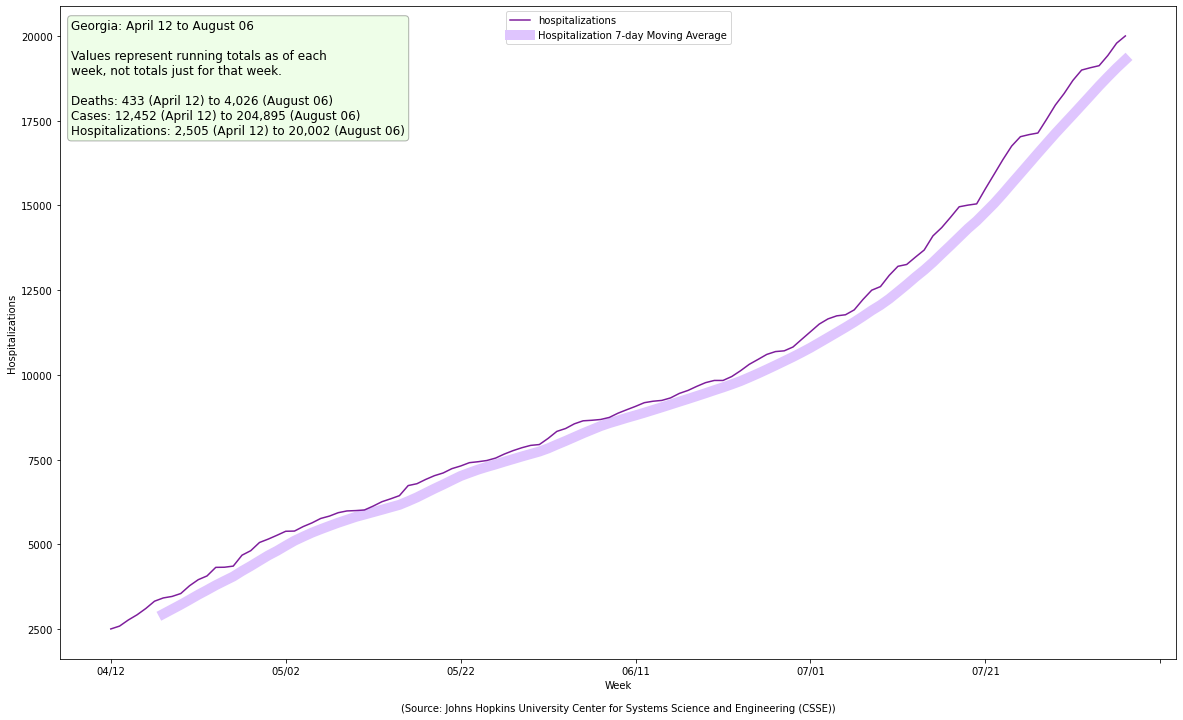

In [45]:
plot_state(df, SOURCE, 'Georgia', image_file='jhu-ga-hosp.png', metrics={MetricType.HOSPITALIZATIONS}, moving_average=True)

#### Mississippi

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f68dd13fac0>)

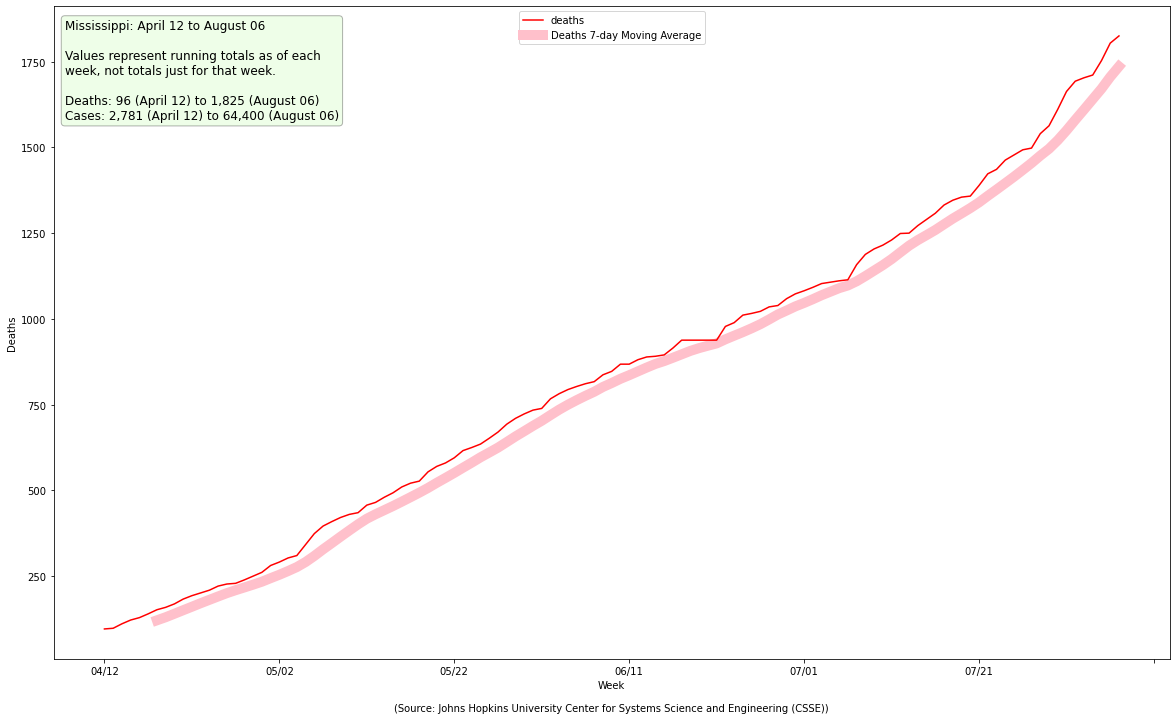

In [46]:
plot_state(df, SOURCE, 'Mississippi', image_file='jhu-ms-deaths.png', metrics={MetricType.DEATHS}, moving_average=True)

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f68dd110370>)

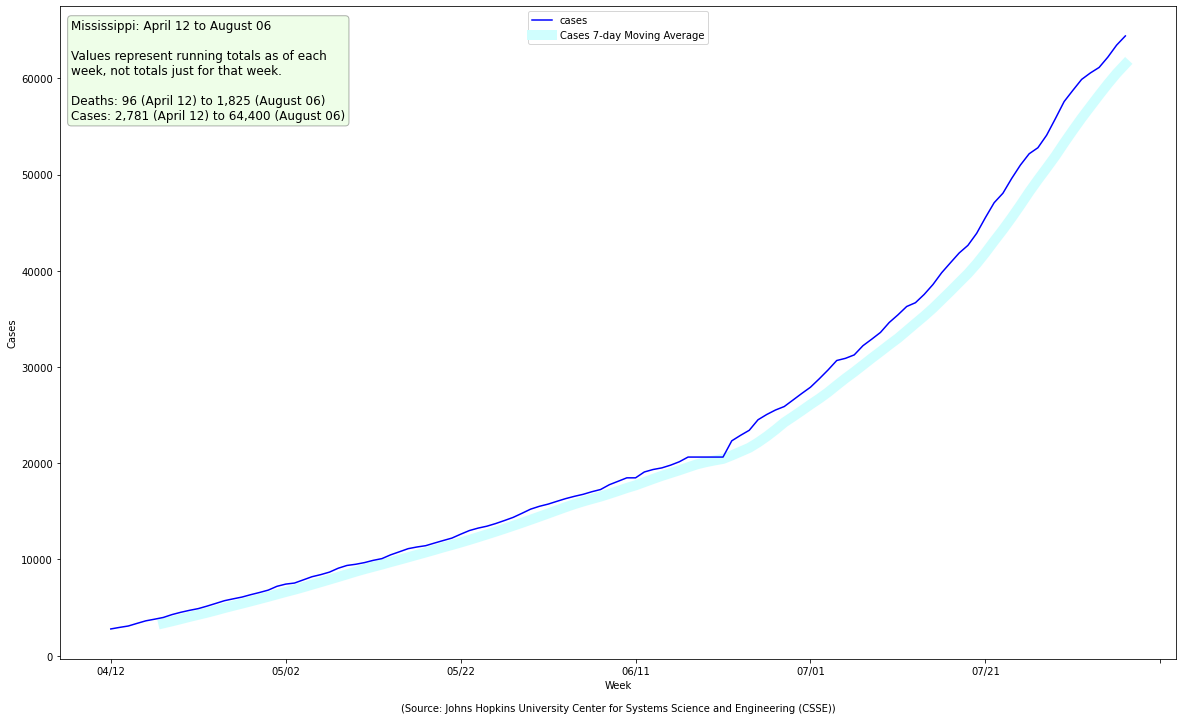

In [47]:
plot_state(df, SOURCE, 'Mississippi', image_file='jhu-ms-cases.png', metrics={MetricType.CASES}, moving_average=True)

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f68dd0b7cd0>)

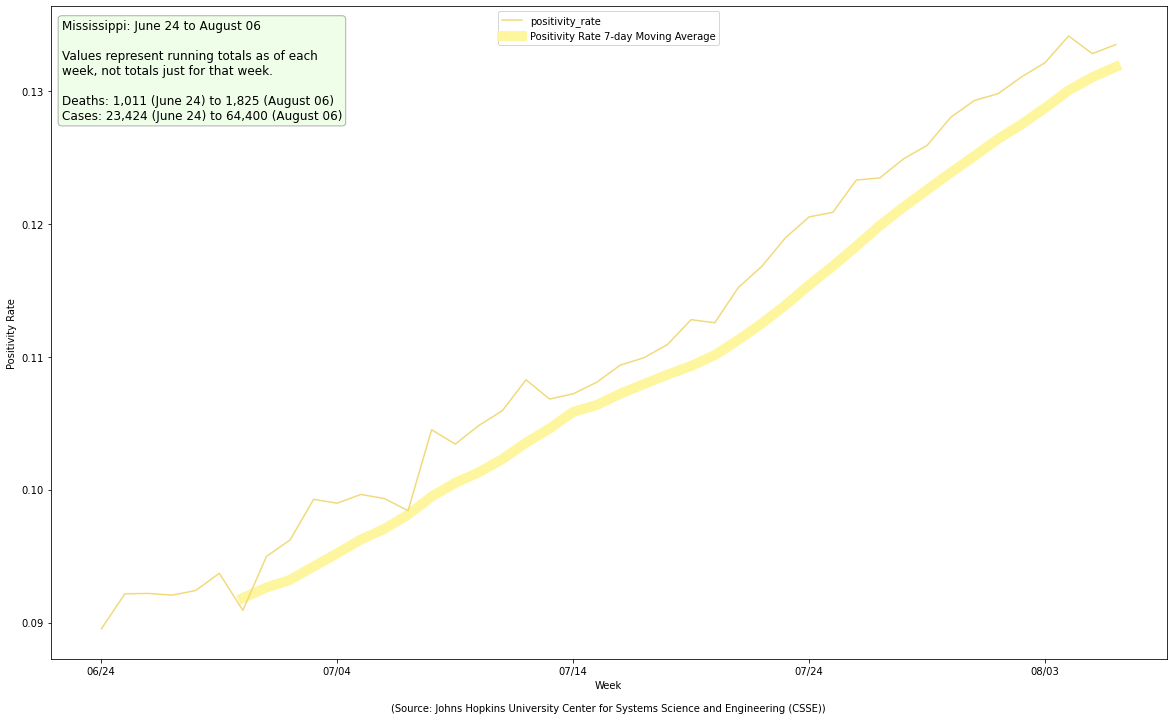

In [48]:
plot_state(df_positivity_dates, SOURCE, 'Mississippi', image_file='jhu-ms-pos.png', metrics={MetricType.POSITIVITY}, moving_average=True)

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f68dd0779a0>)

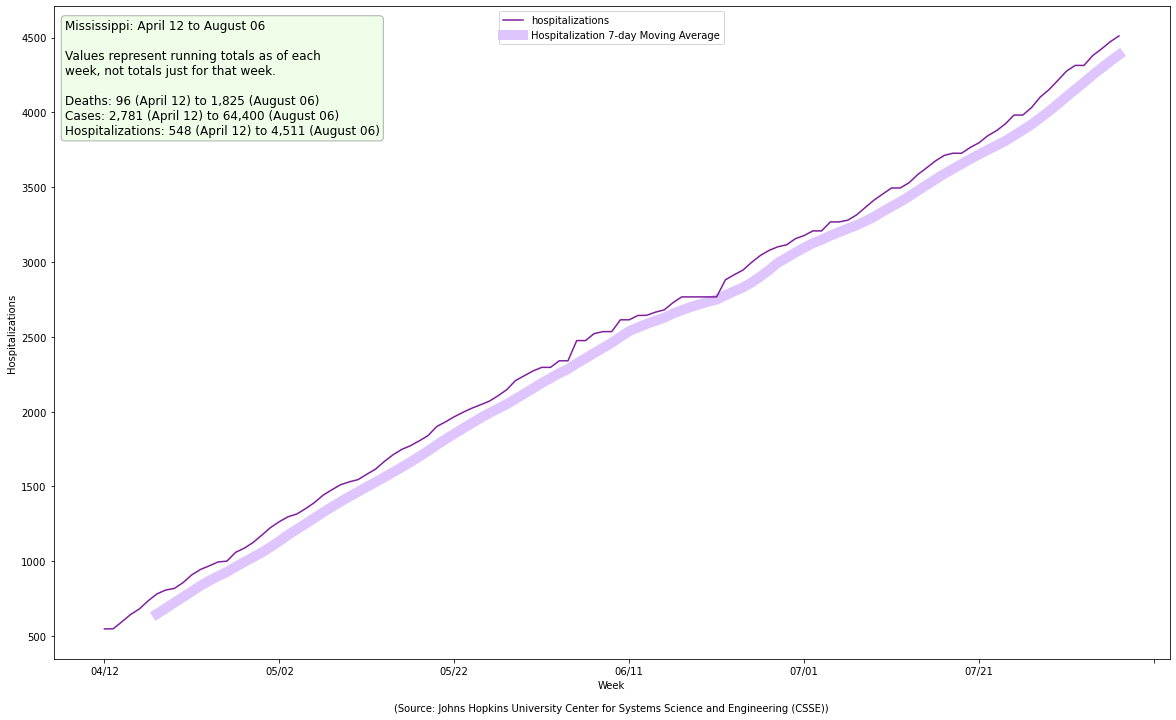

In [49]:
plot_state(df, SOURCE, 'Mississippi', image_file='jhu-ms-hosp.png', metrics={MetricType.HOSPITALIZATIONS}, moving_average=True)

#### Arizona

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f68dd0bcd60>)

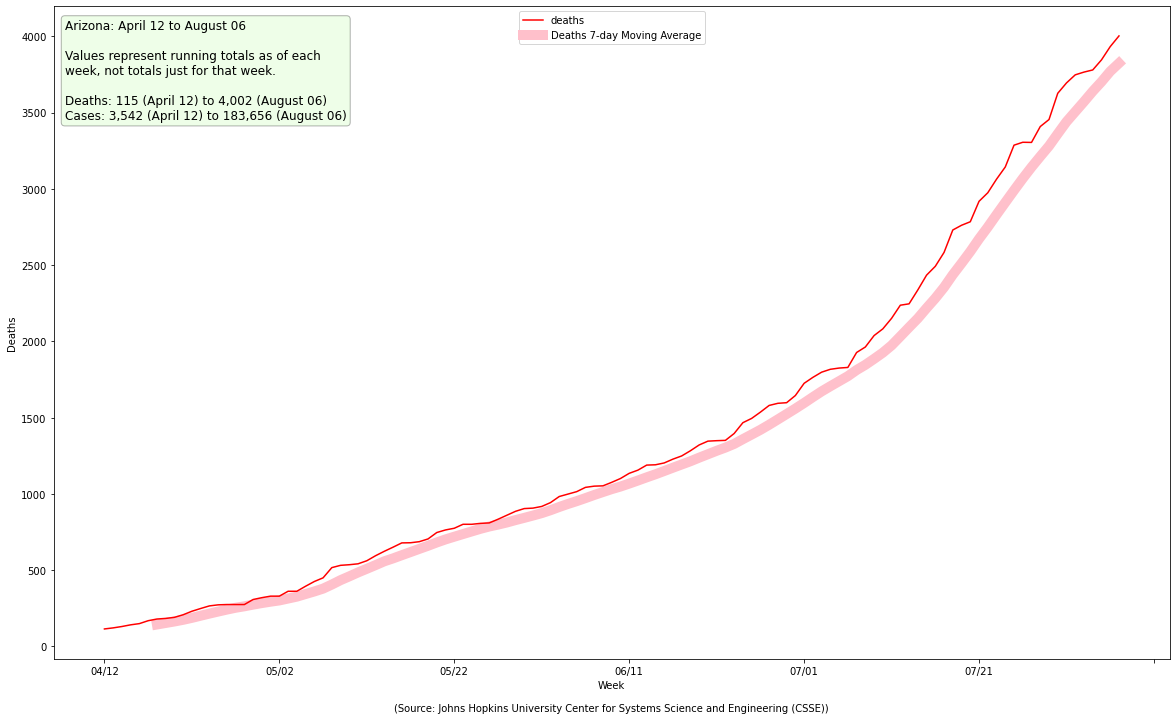

In [50]:
plot_state(df, SOURCE, 'Arizona', image_file='jhu-az-deaths.png', metrics={MetricType.DEATHS}, moving_average=True)

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f68dcf70850>)

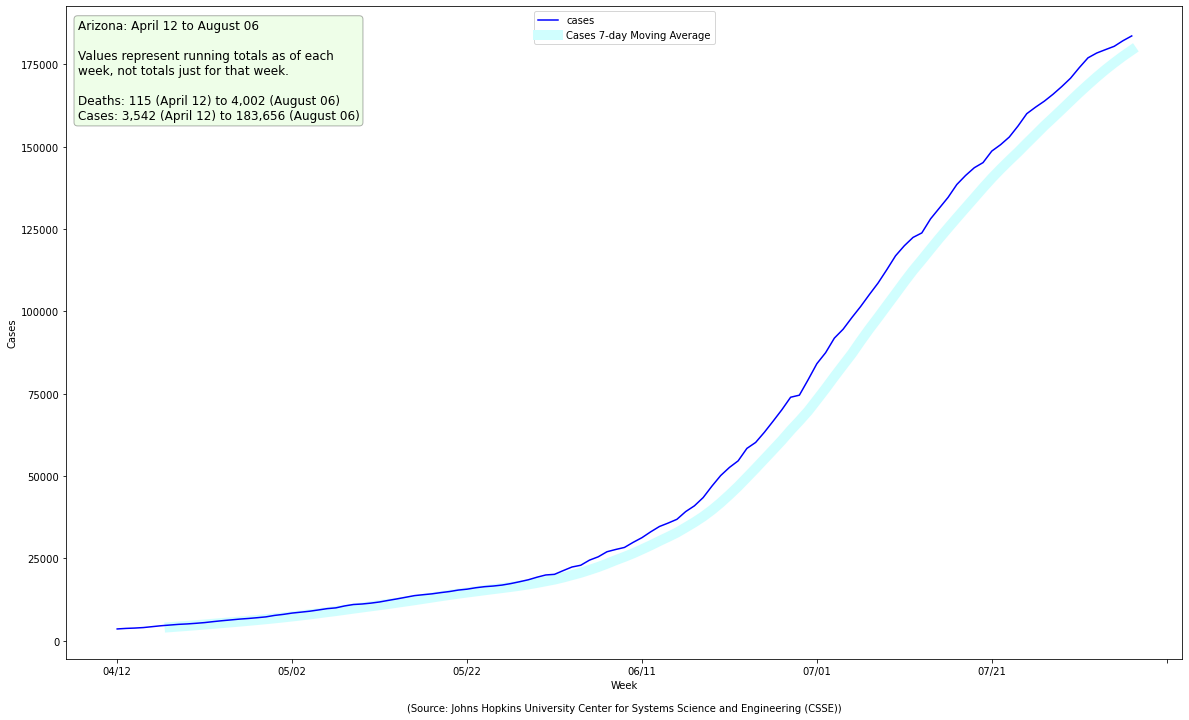

In [51]:
plot_state(df, SOURCE, 'Arizona', image_file='jhu-az-cases.png', metrics={MetricType.CASES}, moving_average=True)

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f68dcf707c0>)

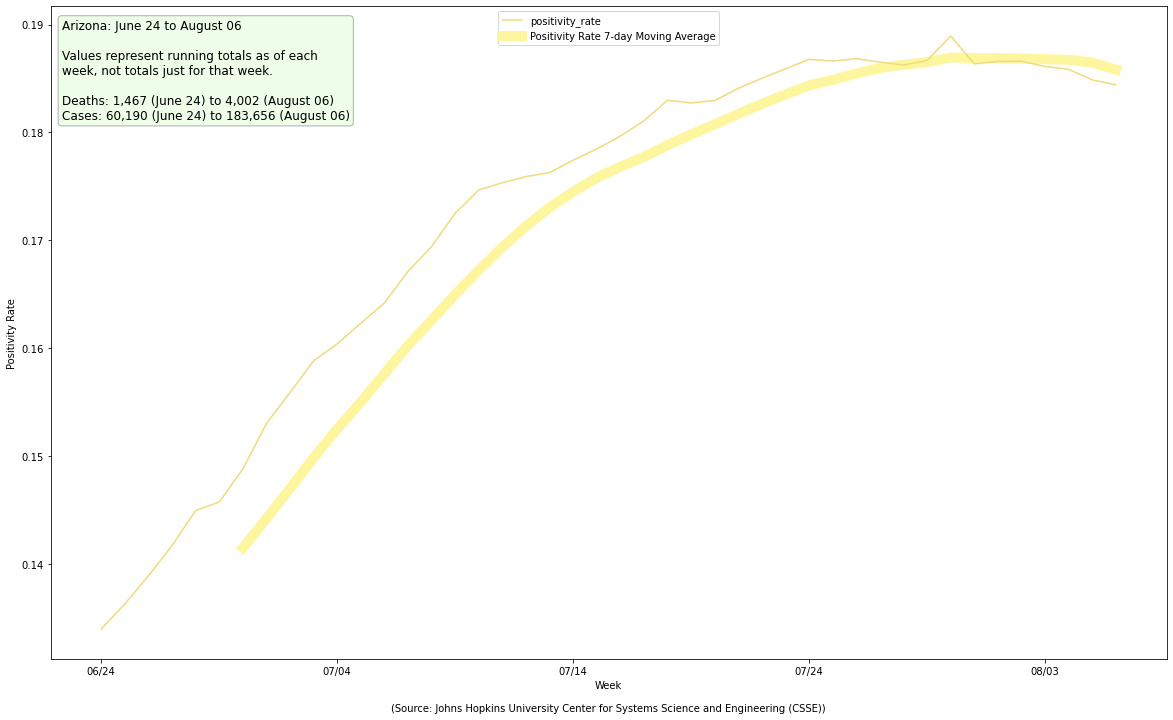

In [52]:
plot_state(df_positivity_dates, SOURCE, 'Arizona', image_file='jhu-az-pos.png', 
           metrics={MetricType.POSITIVITY}, moving_average=True)

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f68dcf29f70>)

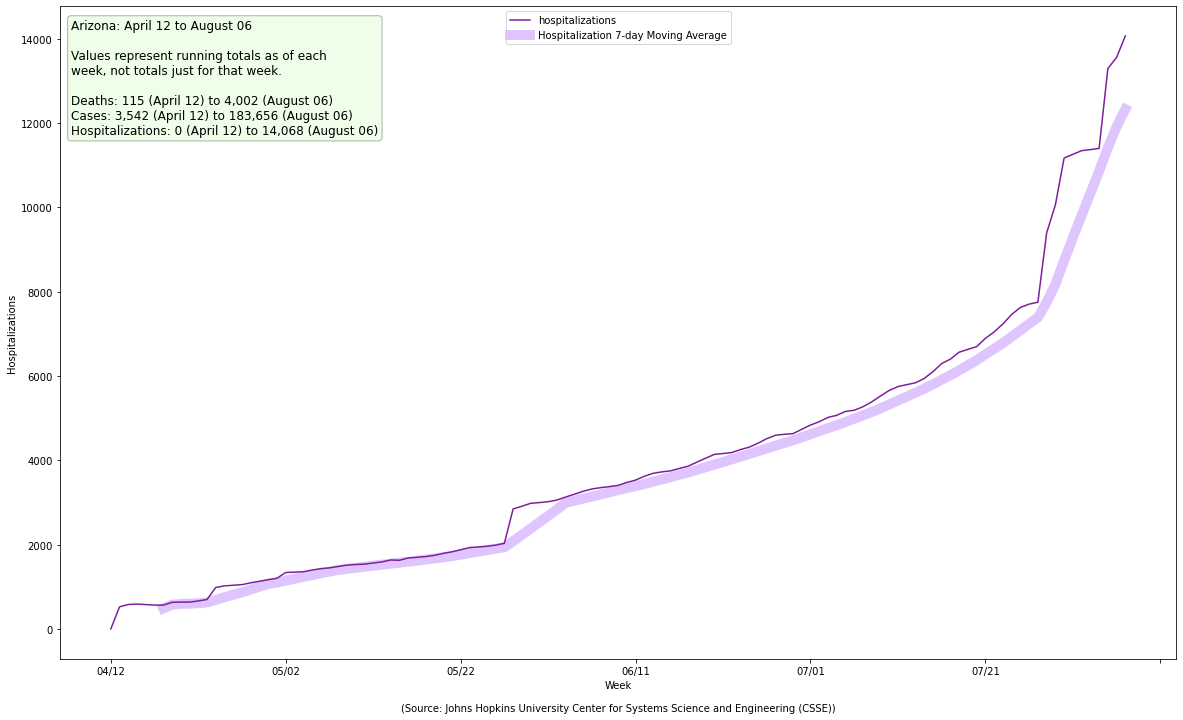

In [53]:
plot_state(df, SOURCE, 'Arizona', image_file='jhu-az-hosp.png', metrics={MetricType.HOSPITALIZATIONS}, moving_average=True)

#### Florida

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f68dd2997f0>)

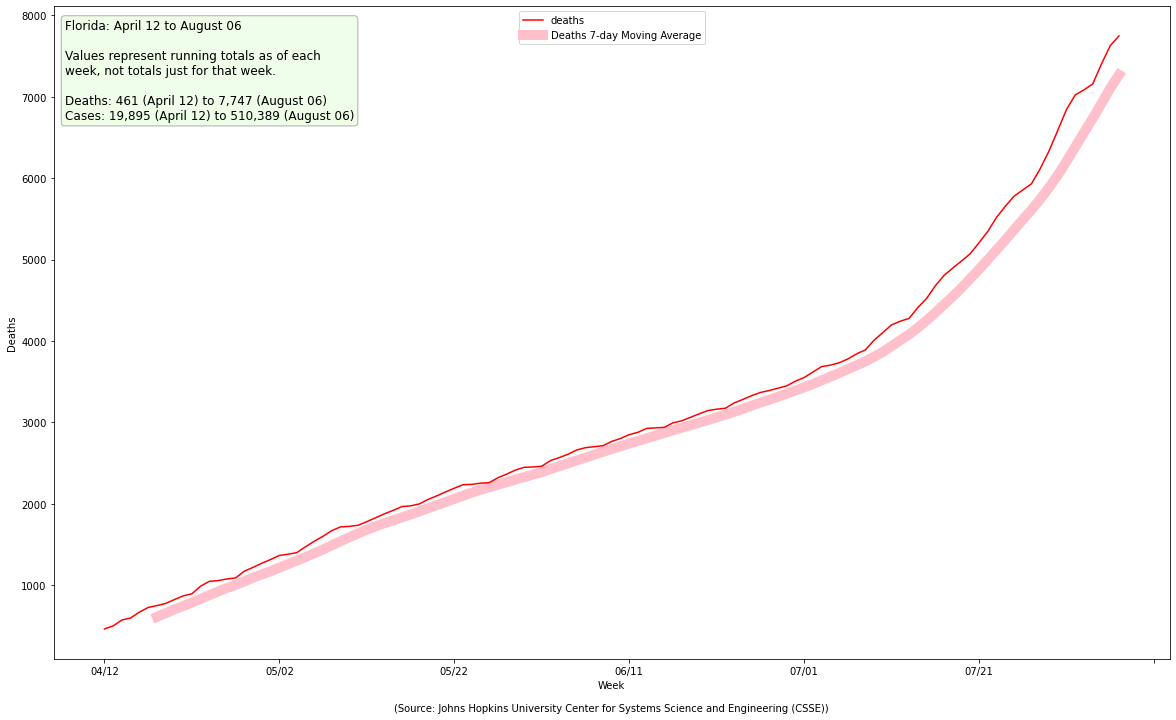

In [54]:
plot_state(df, SOURCE, 'Florida', image_file='jhu-fl-deaths.png', metrics={MetricType.DEATHS}, moving_average=True)

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f68dcdc5670>)

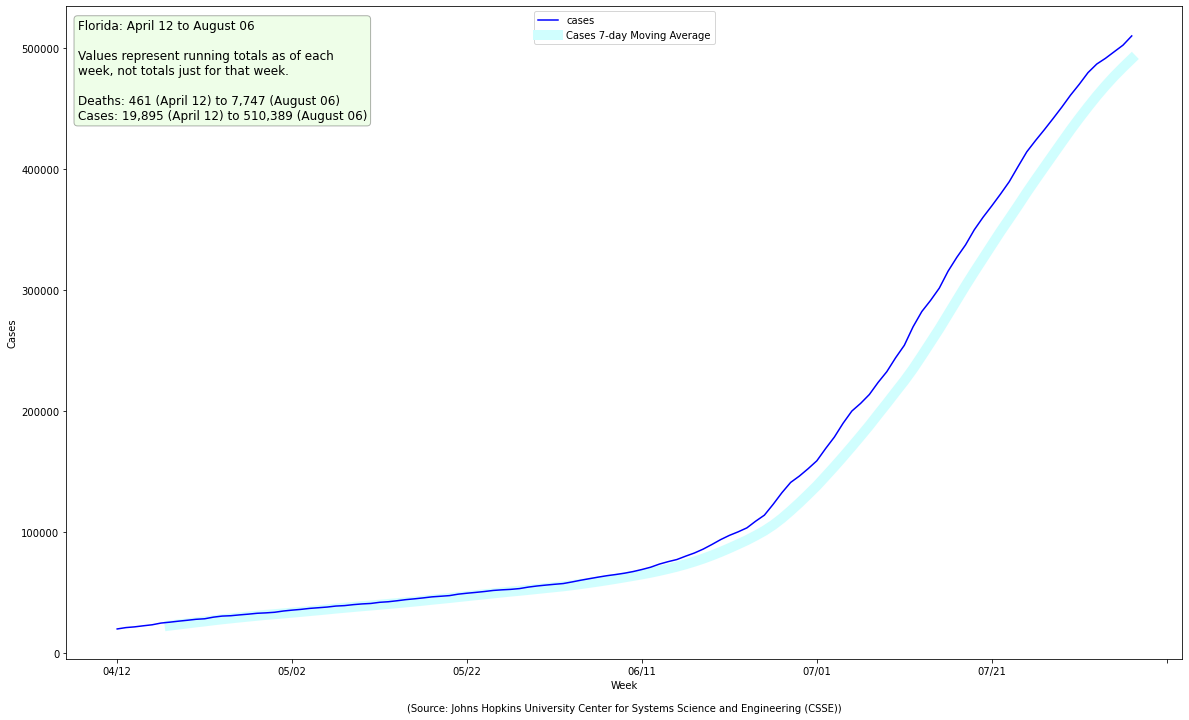

In [55]:
plot_state(df, SOURCE, 'Florida', image_file='jhu-fl-cases.png', metrics={MetricType.CASES}, moving_average=True)

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f68dcdb6130>)

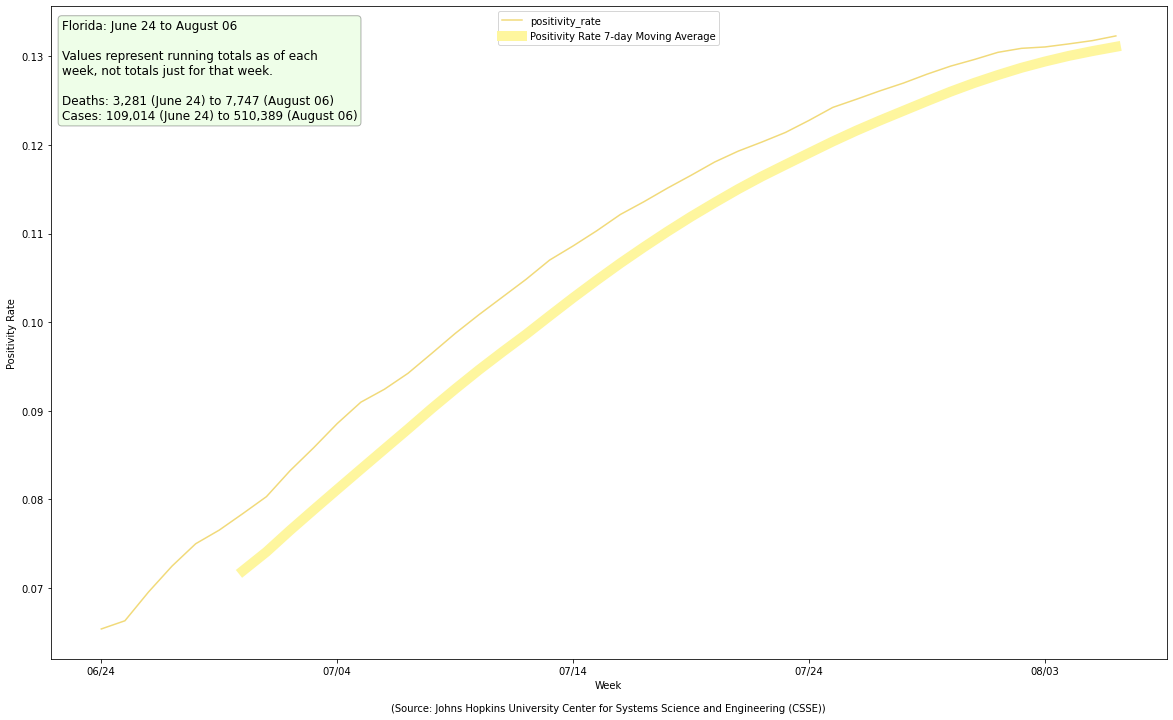

In [56]:
plot_state(df_positivity_dates, SOURCE, 'Florida', image_file='jhu-fl-pos.png', 
           metrics={MetricType.POSITIVITY}, moving_average=True)

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f68dcd5c370>)

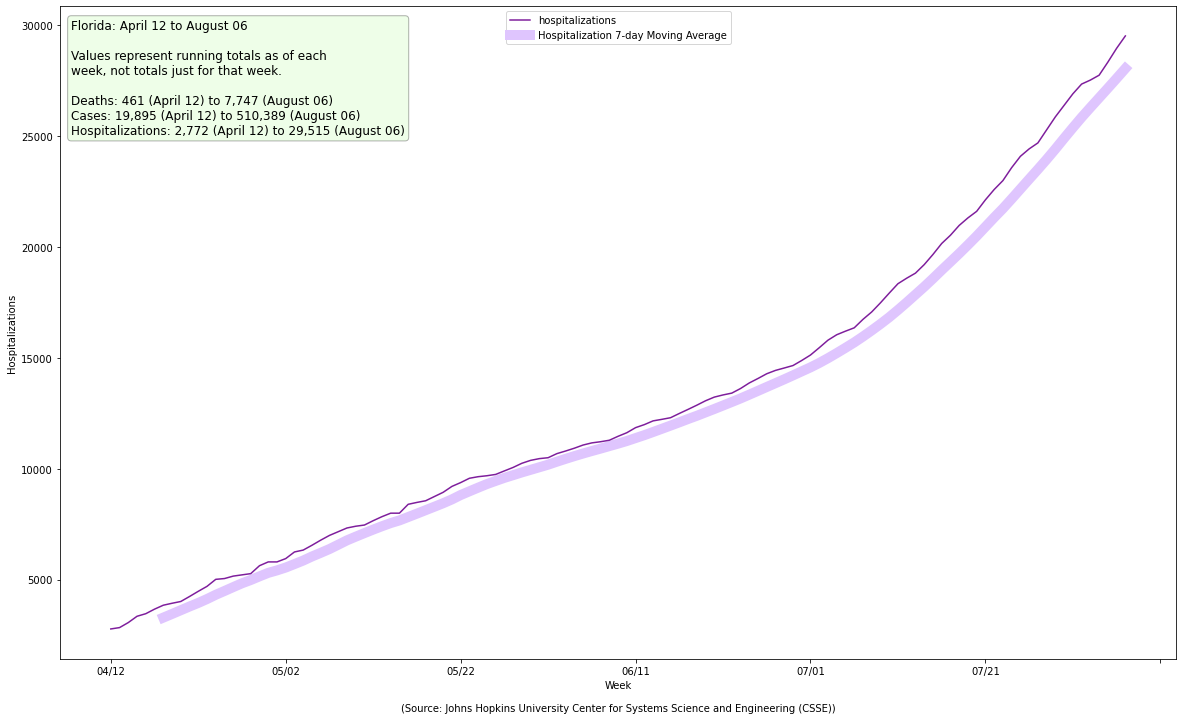

In [57]:
plot_state(df, SOURCE, 'Florida', image_file='jhu-fl-hosp.png', metrics={MetricType.HOSPITALIZATIONS}, moving_average=True)

### South Carolina

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f68dccf1d90>)

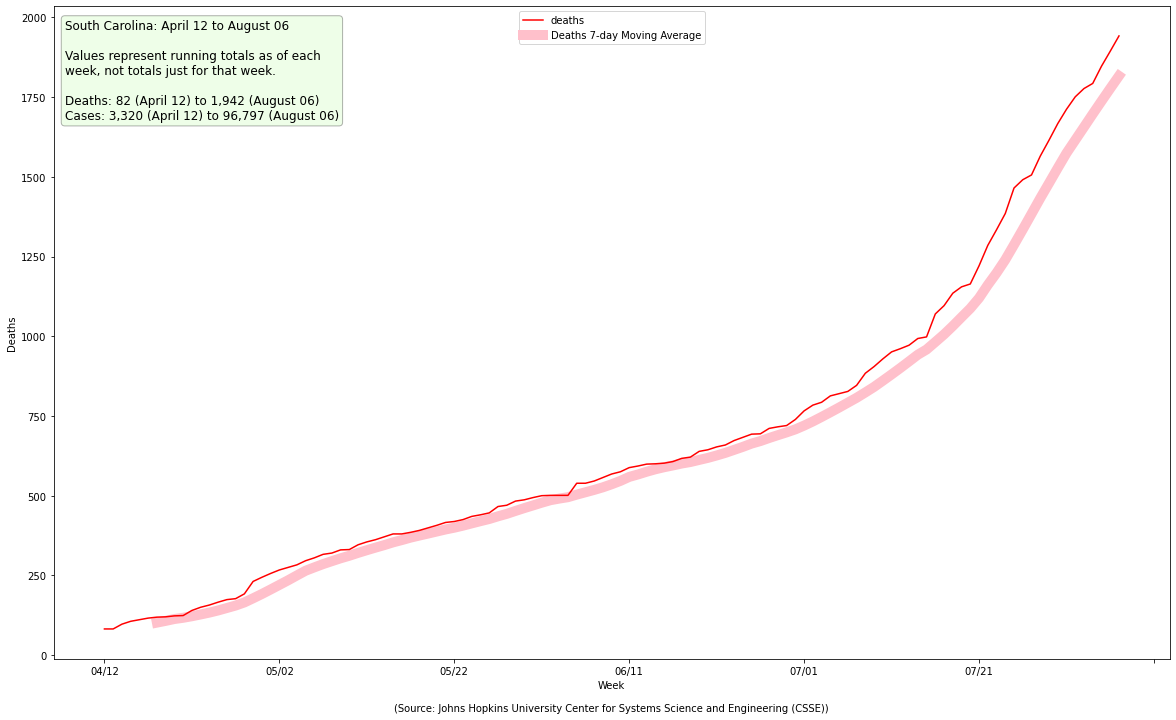

In [58]:
plot_state(df, SOURCE, 'South Carolina', image_file='jhu-sc-deaths.png', metrics={MetricType.DEATHS}, moving_average=True)

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f68dcc77700>)

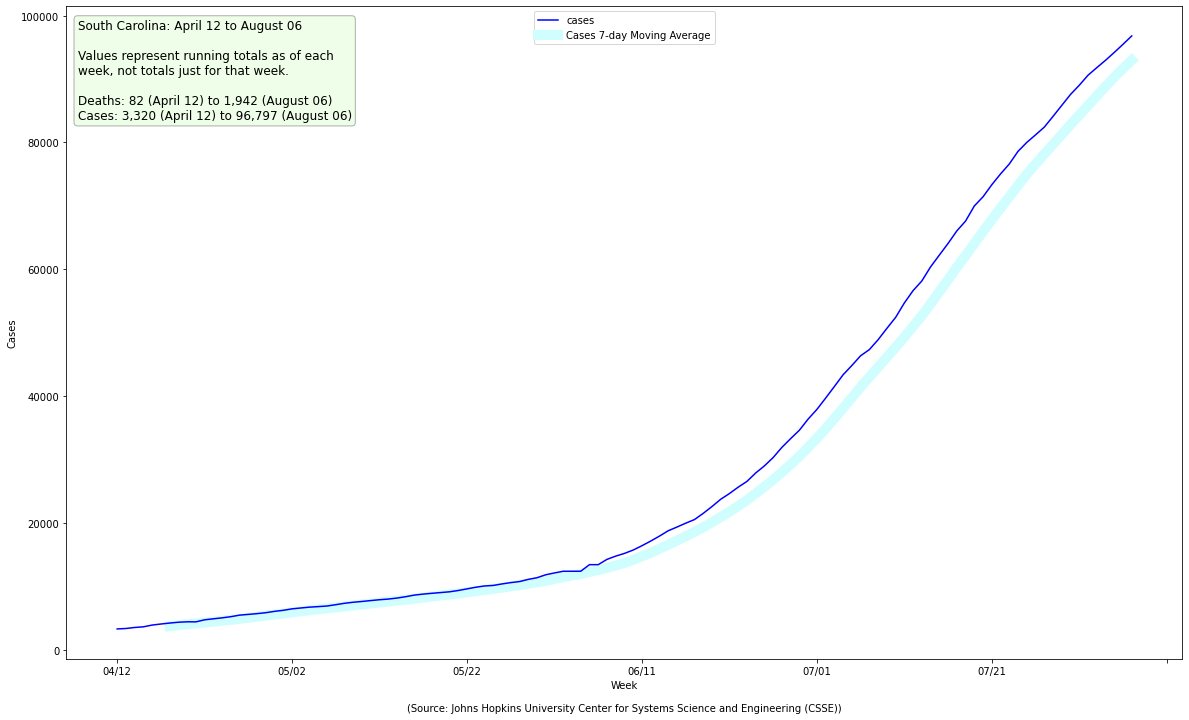

In [59]:
plot_state(df, SOURCE, 'South Carolina', image_file='jhu-sc-cases.png', metrics={MetricType.CASES}, moving_average=True)

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f68dcbdfb20>)

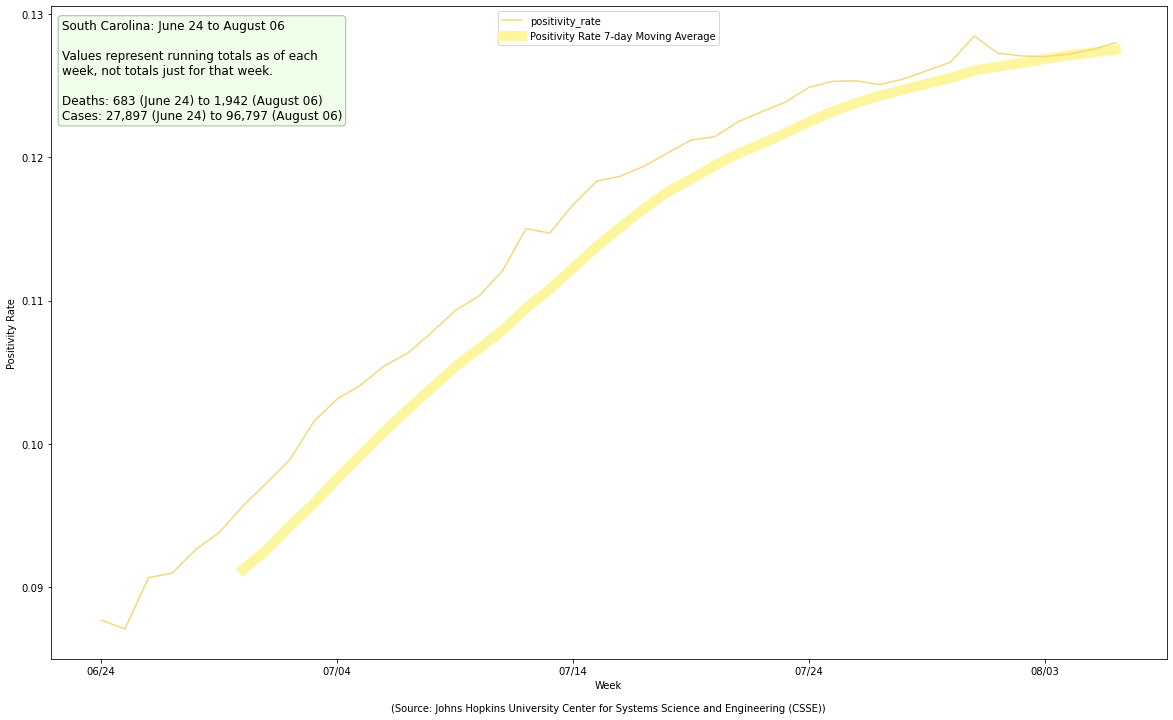

In [60]:
plot_state(df_positivity_dates, SOURCE, 'South Carolina', image_file='jhu-sc-pos.png',
           metrics={MetricType.POSITIVITY}, moving_average=True)

#### Oklahoma

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f68dcb42ca0>)

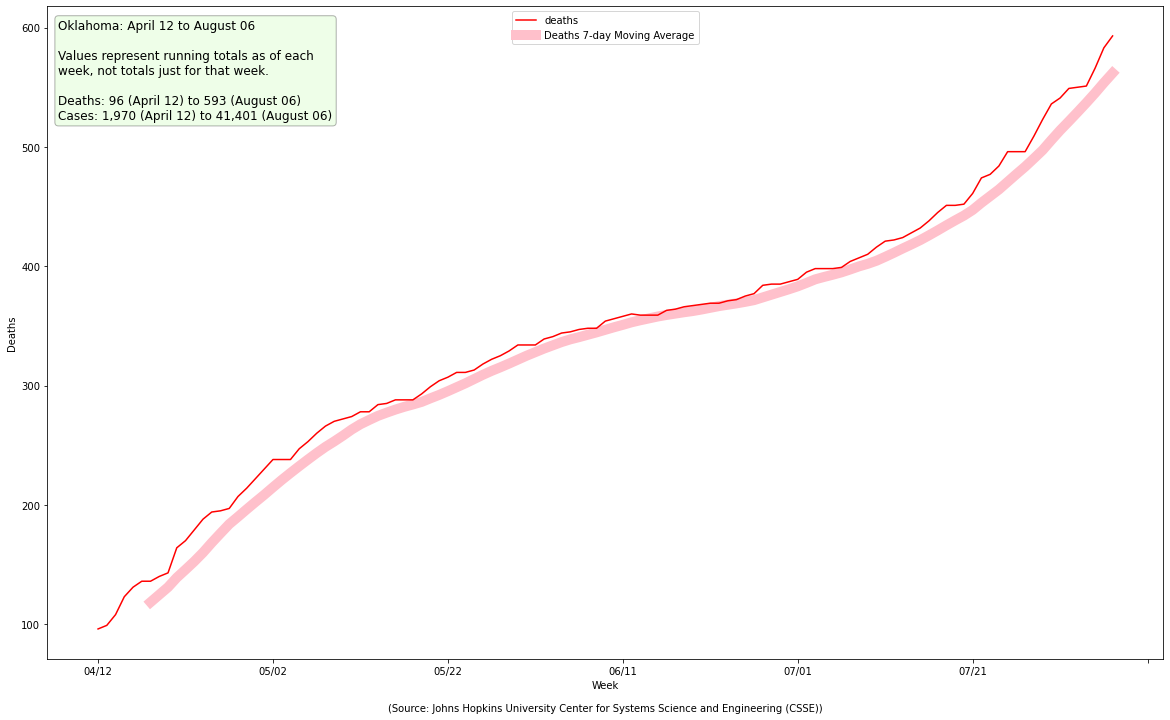

In [61]:
plot_state(df, SOURCE, 'Oklahoma', image_file='jhu-ok-deaths.png', metrics={MetricType.DEATHS}, moving_average=True)

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f68dcb2a580>)

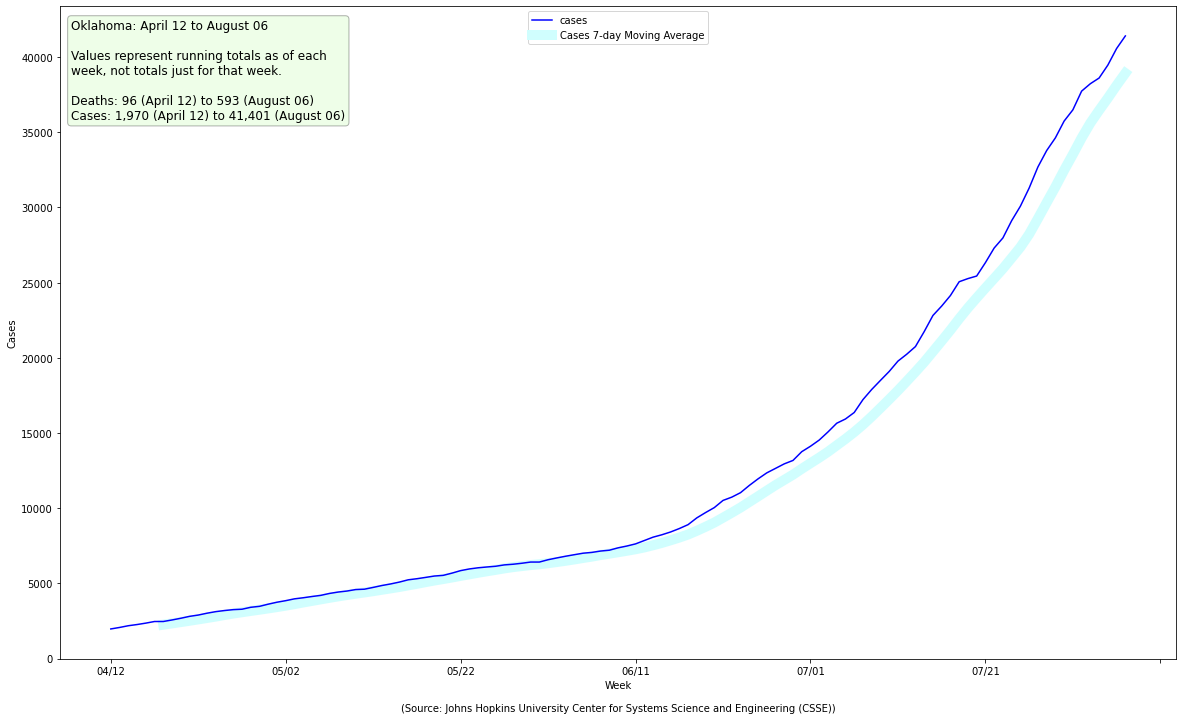

In [62]:
plot_state(df, SOURCE, 'Oklahoma', image_file='jhu-ok-cases.png', metrics={MetricType.CASES}, moving_average=True)

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f68dcacecd0>)

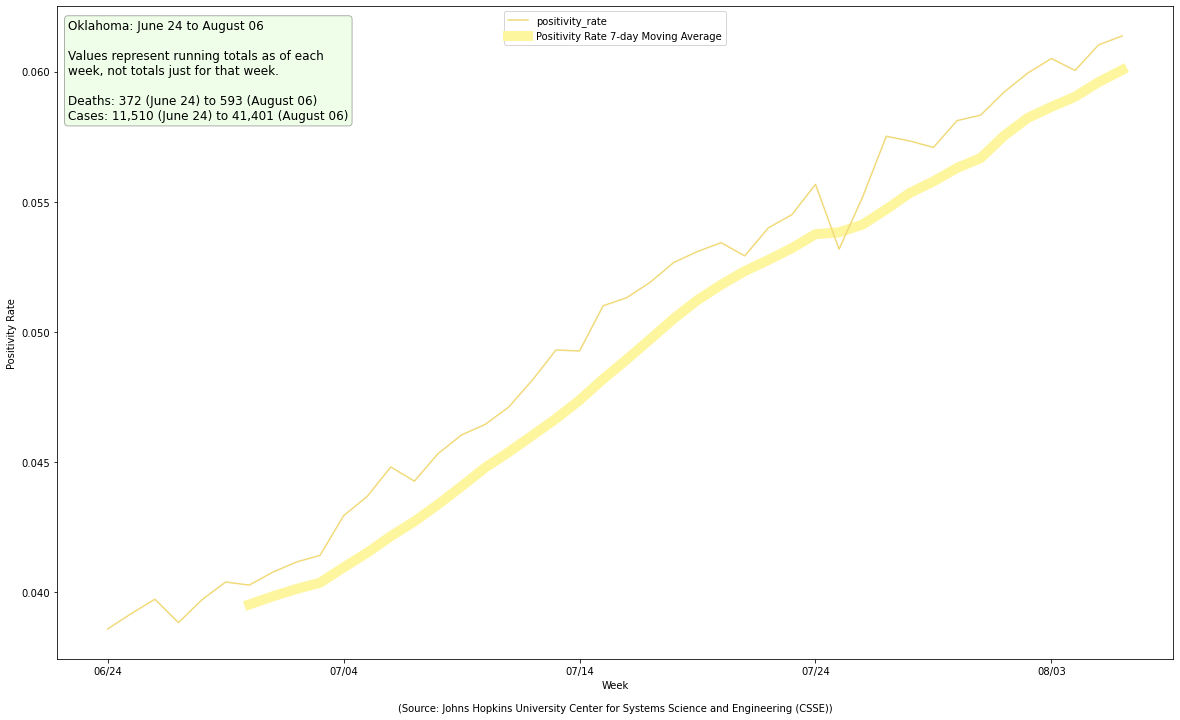

In [63]:
plot_state(df_positivity_dates, SOURCE, 'Oklahoma', image_file='jhu-ok-pos.png', 
           metrics={MetricType.POSITIVITY}, moving_average=True)

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f68dca485e0>)

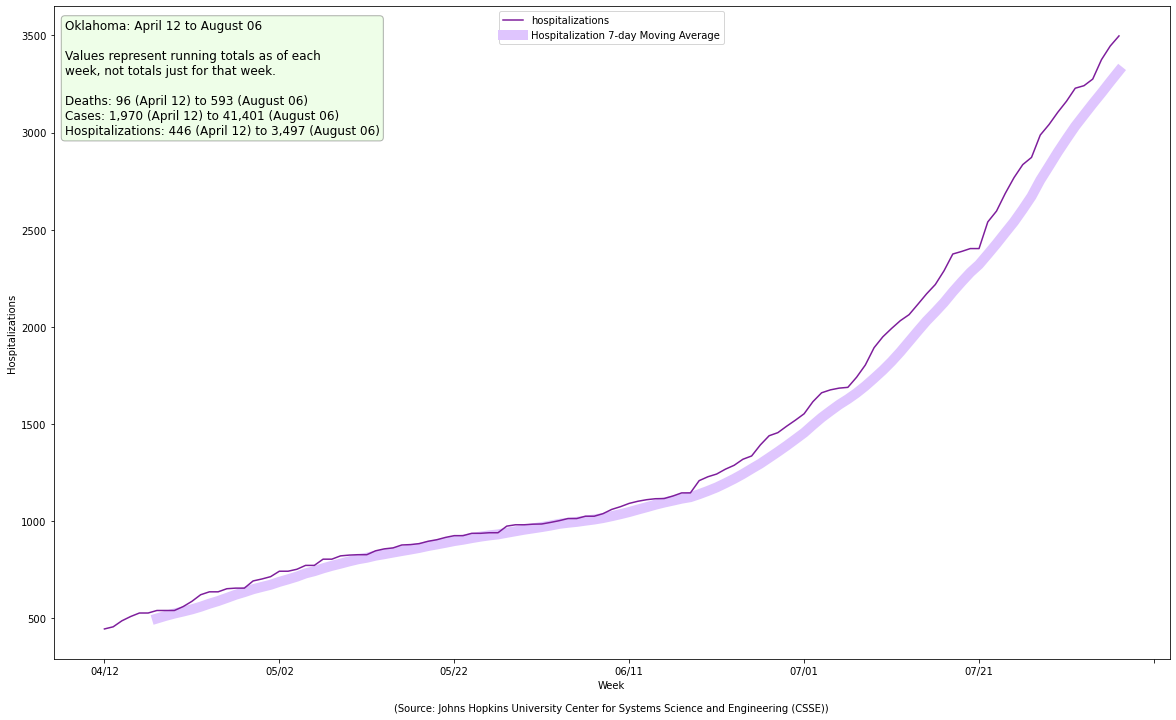

In [64]:
plot_state(df, SOURCE, 'Oklahoma', image_file='jhu-ok-hosp.png', metrics={MetricType.HOSPITALIZATIONS}, moving_average=True)

## Multistate

### Northeast states

Data from some of the states that were hardest hit early on.

In [65]:
ne_states = ('Connecticut', 'New York', 'New Jersey', 'Pennsylvania', 'Delaware', 'Ohio')

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f68dc9c93a0>)

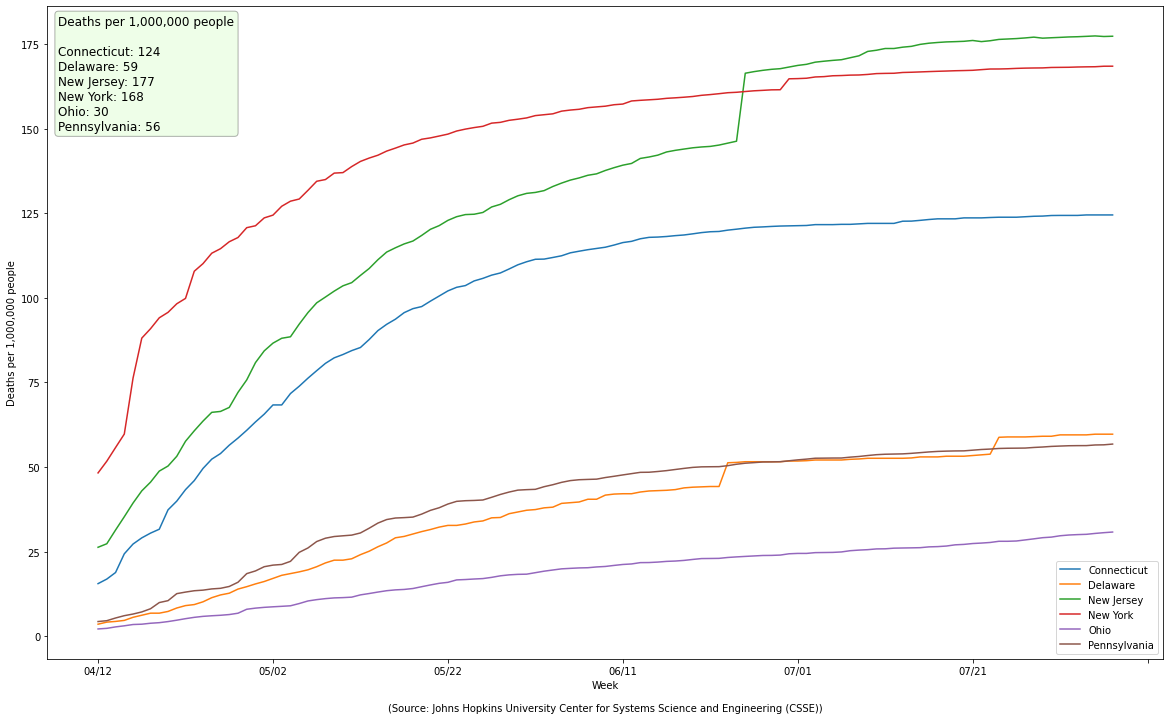

In [66]:
plot_states(df, SOURCE, ne_states, per_n=1_000_000, populations=populations, metric=MetricType.DEATHS,
            image_file='jhu-ne-states-deaths-per-capita.png')

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f68dc97aa60>)

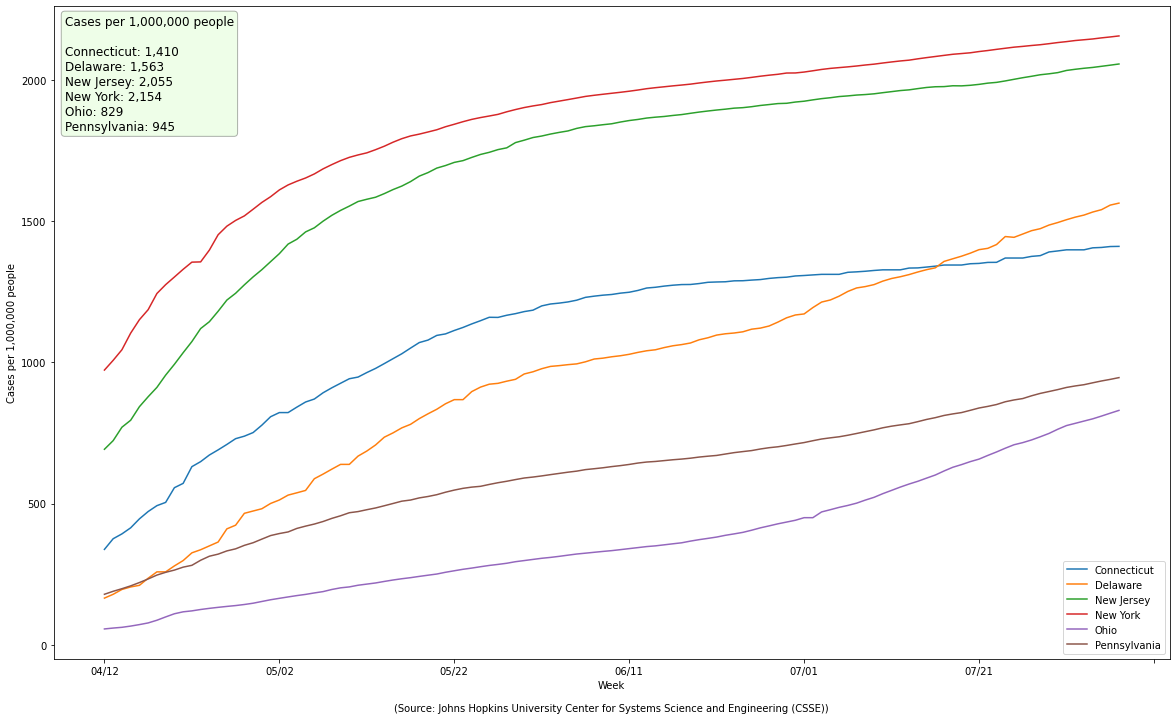

In [67]:
plot_states(df, SOURCE, ne_states, per_n=1_000_000, populations=populations, metric=MetricType.CASES,
            image_file='jhu-ne-states-cases-per-capita.png')

### South and southwestern states

Data from some of the states hard hit in mid-2020.

In [68]:
s_sw_states = ('Arizona', 'Texas', 'Oklahoma', 'South Carolina', 'Utah', 'California', 'Florida')

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f68dc8bcee0>)

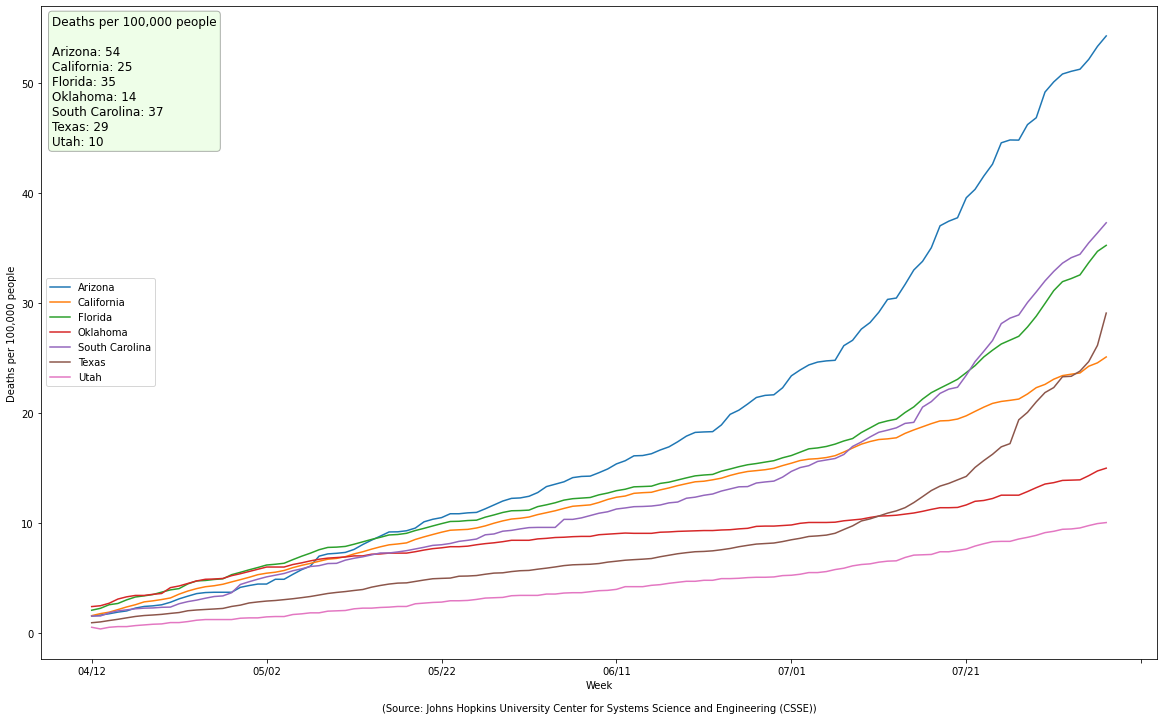

In [69]:
plot_states(df, SOURCE, s_sw_states, per_n=100_000, populations=populations, metric=MetricType.DEATHS,
            legend_loc='center left', image_file='jhu-s-sw-states-deaths-per-capita.png')

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f68dc8b6b50>)

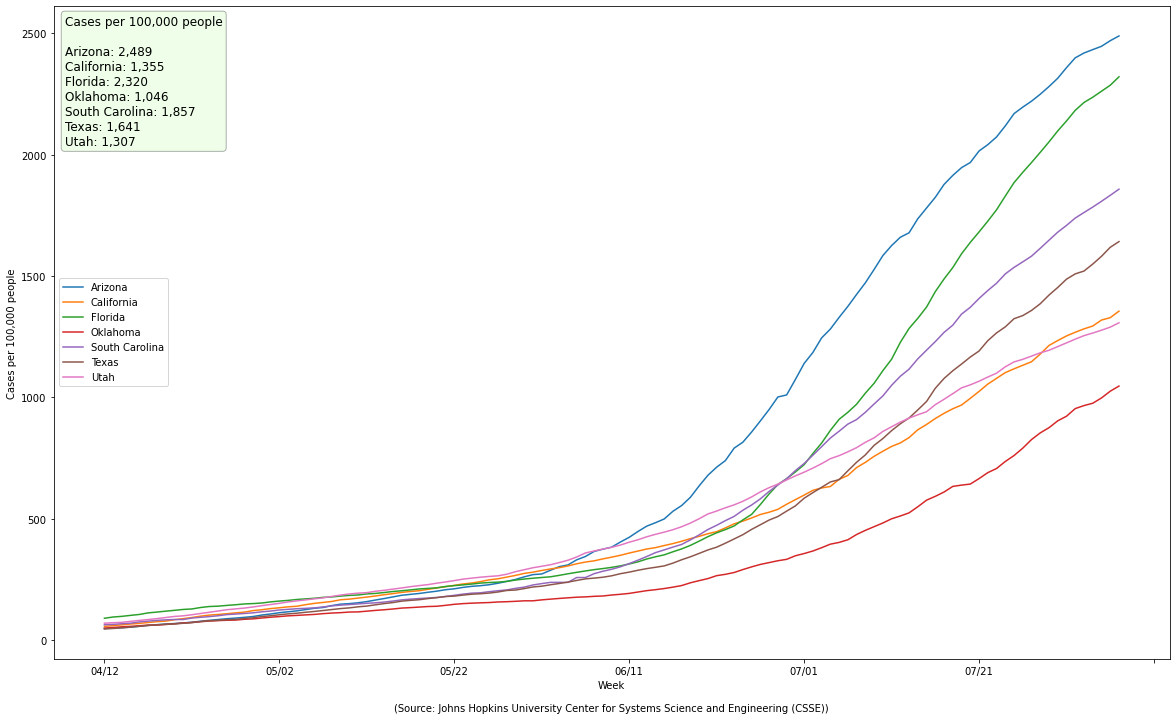

In [70]:
plot_states(df, SOURCE, s_sw_states, per_n=100_000, populations=populations, metric=MetricType.CASES,
            legend_loc='center left', image_file='jhu-s-sw-states-cases-per-capita.png')

How are some of these states doing, compared to Pennsylvania (my home state)?

In [71]:
s_sw_plus_pa = s_sw_states + ('Pennsylvania',)

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f68dc7bfd60>)

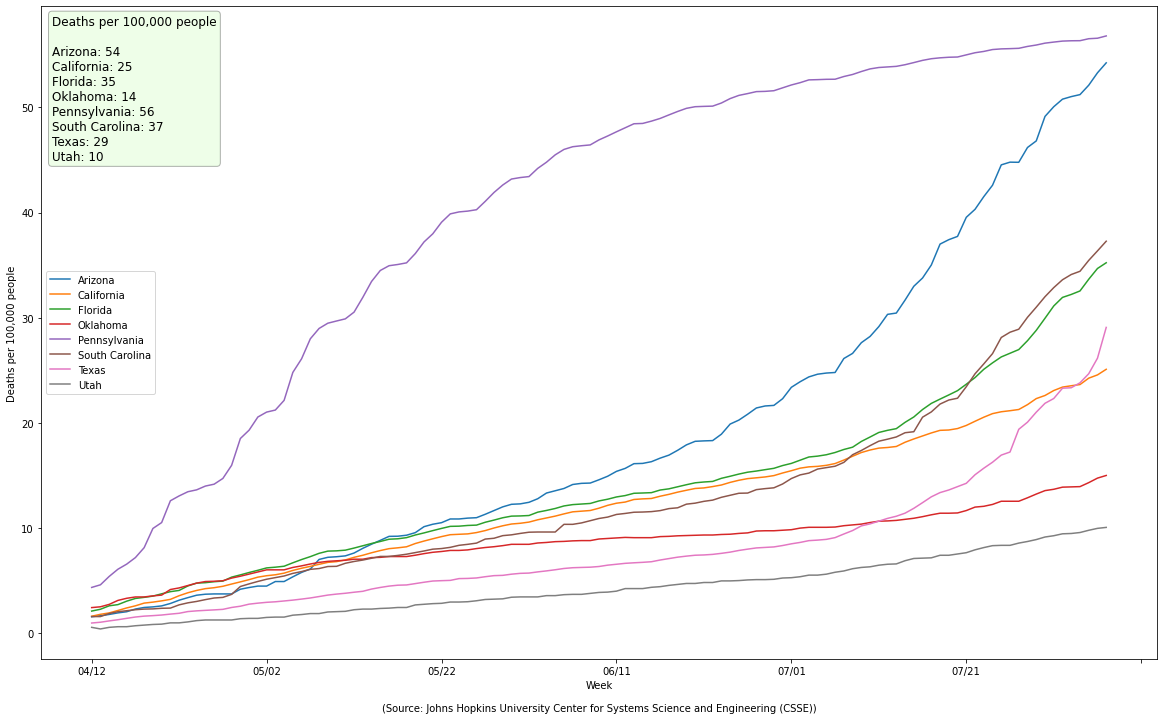

In [72]:
plot_states(df, SOURCE, s_sw_plus_pa, per_n=100_000, populations=populations, metric=MetricType.DEATHS, 
            legend_loc='center left', image_file='jhu-s-sw-states-with-pa-deaths-per-capita.png')

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f68dc750df0>)

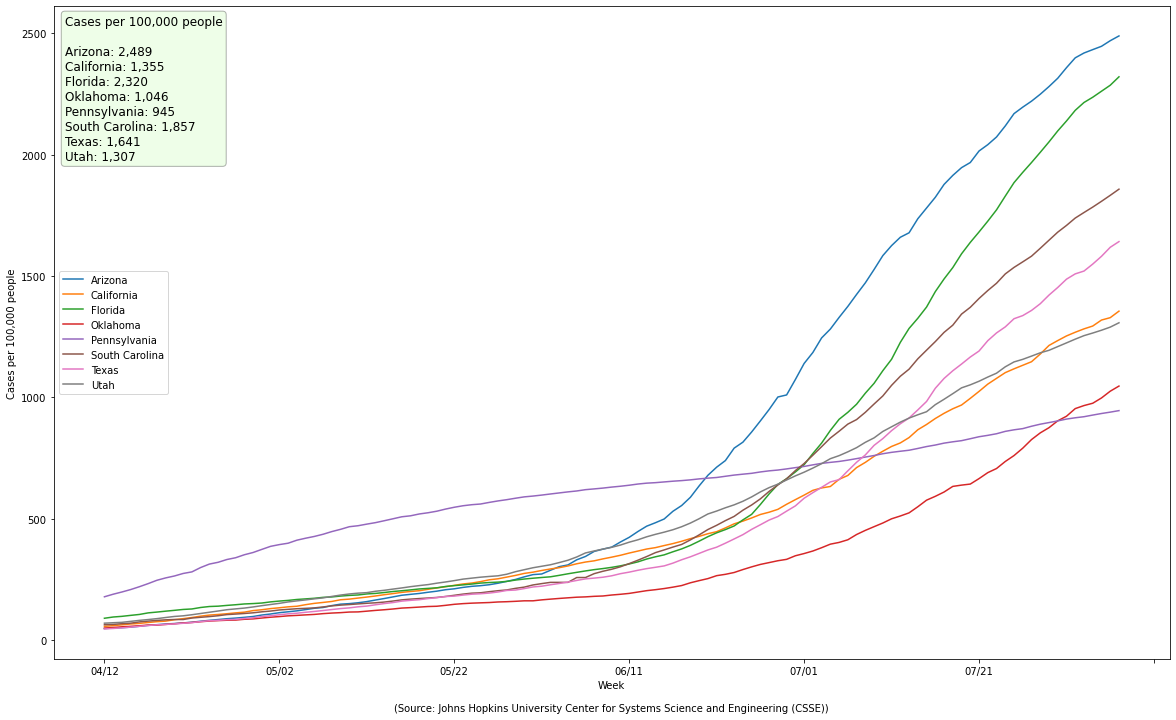

In [73]:
plot_states(df, SOURCE, s_sw_plus_pa, per_n=100_000, populations=populations, metric=MetricType.CASES,
            legend_loc='center left', image_file='jhu-s-sw-states-with-pa-cases-per-capita.png')

## Per-capita rates for all states

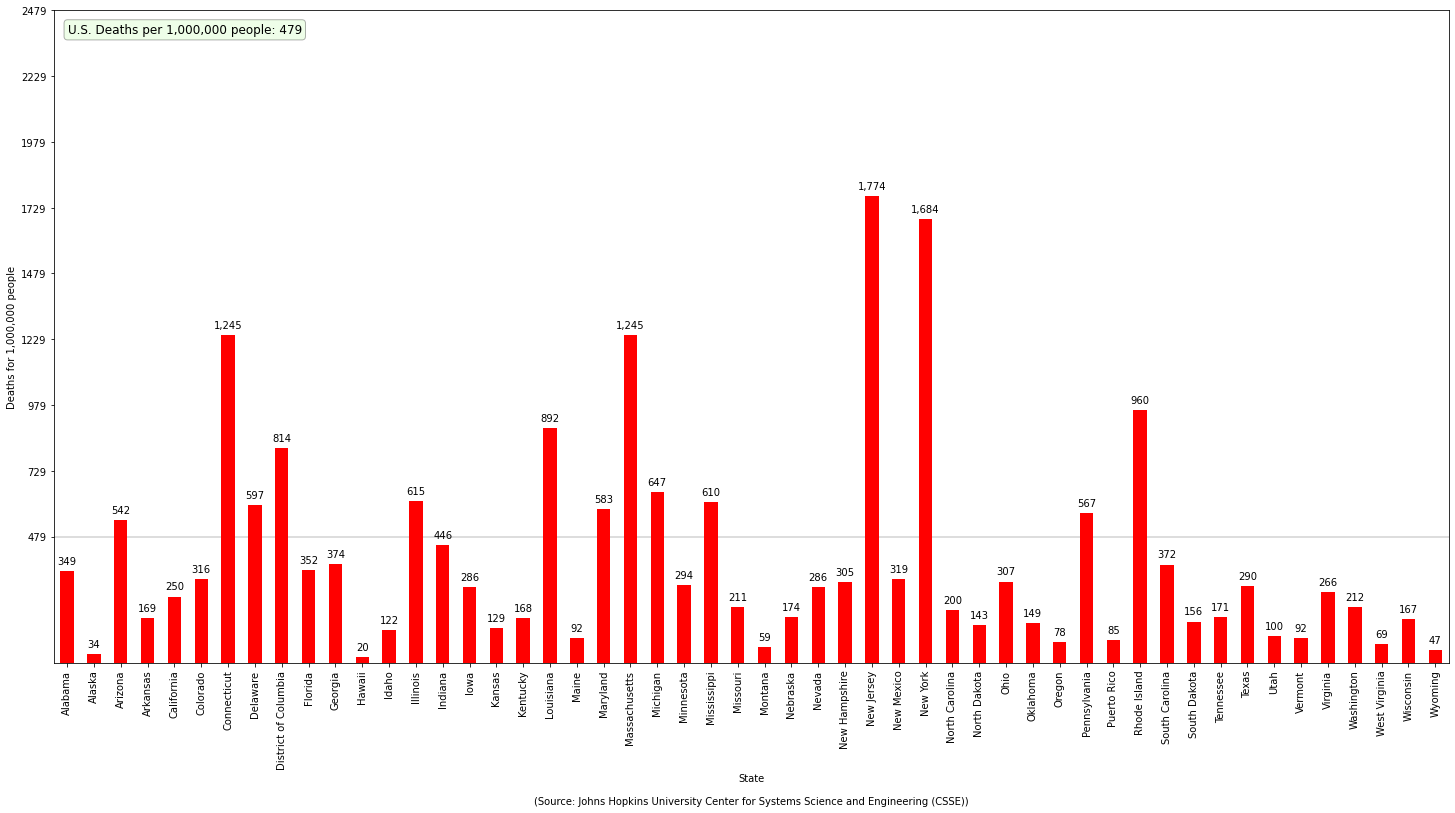

In [74]:
plot_states_per_capita(df, SOURCE, populations, image_file='jhu-state-deaths-per-capita.png');

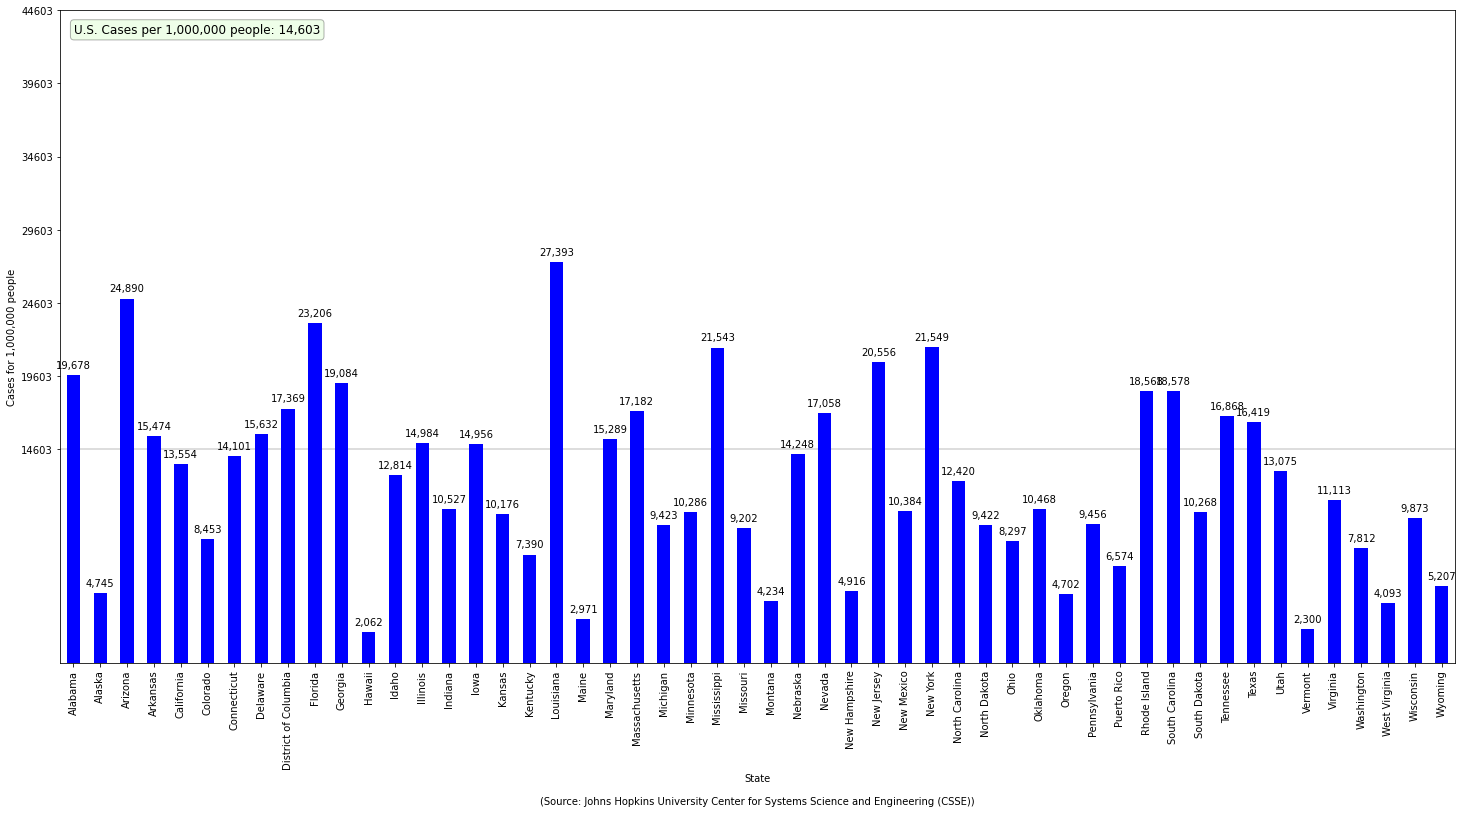

In [75]:
plot_states_per_capita(df, SOURCE, populations, metric=MetricType.CASES, image_file='jhu-state-cases-per-capita.png');